# References

[Course Webpage](https://sites.google.com/view/berkeley-cs294-158-sp20/home)

[1] Pathak, Deepak, et al. "Context encoders: Feature learning by inpainting." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

[2] Gidaris, Spyros, Praveer Singh, and Nikos Komodakis. "Unsupervised representation learning by predicting image rotations." arXiv preprint arXiv:1803.07728 (2018).

[3] Chen, Ting, et al. "A simple framework for contrastive learning of visual representations." arXiv preprint arXiv:2002.05709 (2020).

[4] Noroozi, Mehdi, and Paolo Favaro. "Unsupervised learning of visual representations by solving jigsaw puzzles." European Conference on Computer Vision. Springer, Cham, 2016.

[5] Wang, Xiaolong, Allan Jabri, and Alexei A. Efros. "Learning correspondence from the cycle-consistency of time." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2019.

[6] Oord, Aaron van den, Yazhe Li, and Oriol Vinyals. "Representation learning with contrastive predictive coding." arXiv preprint arXiv:1807.03748 (2018).

[7] Hénaff, Olivier J., et al. "Data-efficient image recognition with contrastive predictive coding." arXiv preprint arXiv:1905.09272 (2019).

[8] Tian, Yonglong, Dilip Krishnan, and Phillip Isola. "Contrastive multiview coding." arXiv preprint arXiv:1906.05849 (2019).

[9] He, Kaiming, et al. "Momentum contrast for unsupervised visual representation learning." arXiv preprint arXiv:1911.05722 (2019).

[10] Doersch, Carl, Abhinav Gupta, and Alexei A. Efros. "Unsupervised visual representation learning by context prediction." Proceedings of the IEEE International Conference on Computer Vision. 2015.

[11] Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

# Getting Started
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

In [134]:
!if [ -d cs294-158-ssl ]; then rm -Rf cs294-158-ssl; fi
!git clone https://github.com/ckurtz/cs294-158-ssl
#!pip install cs294-158-ssl/

import os
os.chdir('cs294-158-ssl')

-d �tait inattendu.
Cloning into 'cs294-158-ssl'...


Run the cells below to download the necessary pretrained models. It should take a few minutes.

In [133]:
!wget https://camille-kurtz.com/teaching/data.zip
!unzip -qq data.zip
!rm data.zip

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [132]:
!wget https://camille-kurtz.com/teaching/results.zip
!unzip -qq results.zip
!rm results.zip

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


The models and demos shown were pre-trained. The code used for all the demos can be found in the github repo [here](https://github.com/wilson1yan/cs294-158-ssl). Follow the README to train models on CIFAR10 or ImageNet.

# Self-Supervised Learning Tasks
Self-supervised learning is a rapidly growing field, its success largely accelerated by growing compute and the vast amount of unlabeled data available for training. The hope is that by pretraining on specially designed self-supervised tasks, the models would be able to learn semantically meaningful representations to be used for downstream tasks. In the following demos, we will look at a few examples of these self-supervised tasks.

In [131]:
from deepul_helper.demos import load_model_and_data, evaluate_accuracy, display_nearest_neighbors, show_context_encoder_inpainting

%matplotlib inline

## Demo 1: Context Encoder [[1]](https://arxiv.org/abs/1604.07379)

The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$
However, this demo does not use the adversarial portion of the loss.

### Example Code

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContextEncoder(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes):
        super().__init__()
        input_channels = 3

        self.latent_dim = 4000

        # Encodes the masked image
        self.encoder = nn.Sequential(
            # 128 x 128 Input
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1), # 64 x 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # 32 x 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, self.latent_dim, 4) # 1 x 1
        )

        # Only reconstructs the masked part of the image and not the whole image
        self.decoder = nn.Sequential(
           nn.BatchNorm2d(self.latent_dim),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(self.latent_dim, 512, 4, stride=1, padding=0), # 4 x 4
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 8 x 8
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 16 x 16
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 32 x 32
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(64, input_channels, 4, stride=2, padding=1), # 64 x 64
           nn.Tanh()
        )

        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(self.latent_dim, affine=False),
            nn.Linear(self.latent_dim, self.n_classes)
        )
        return classifier

    def forward(self, images):
        # Extract a 64 x 64 center from 128 x 128 image
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        # Mask out a 64 x 64 center with slight overlap
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        return dict(Loss=F.mse_loss(center_recon, images_center)), torch.flatten(z, 1)

    def encode(self, images):
        images_masked = images
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0
        return self.encoder(images_masked)

    def reconstruct(self, images):
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        images_masked[:, 0, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        images_recon = images_masked.clone()
        images_recon[:, :, 32:32+64, 32:32+64] = center_recon
        return images_masked, images_recon


### Inpainting Examples
For each pair of images, the left image is the masked input and the right the inpainted reconstruction.

In [ ]:
show_context_encoder_inpainting()

### Linear Classification
By design the model architecture is an encoder -> decoder module. We can use the bottleneck layer as our learned representation. Below, we show linear classification accuracy results on CIFAR10 using the learned representations.

In [ ]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('context_encoder')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


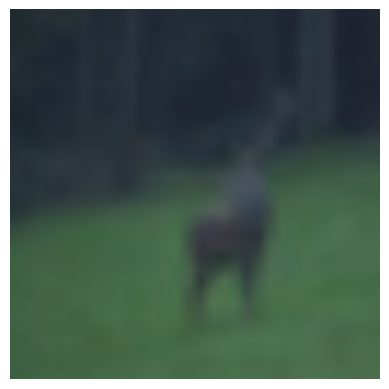

Top 16 Nearest Neighbors (in latent space)


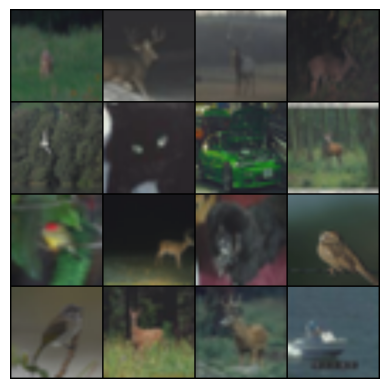

Image 2


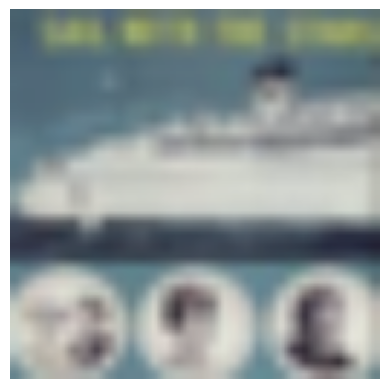

Top 16 Nearest Neighbors (in latent space)


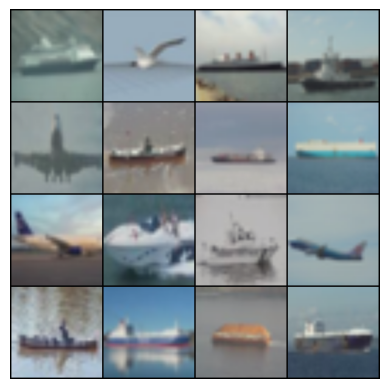

Image 3


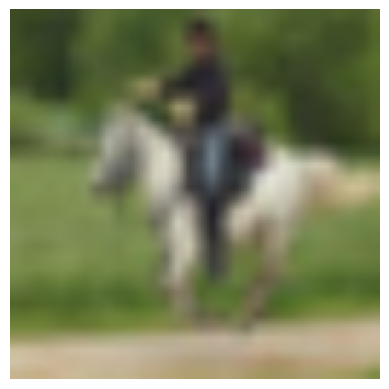

Top 16 Nearest Neighbors (in latent space)


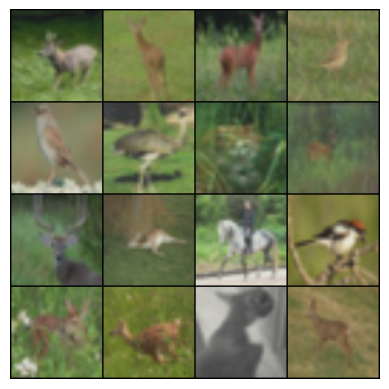

Image 4


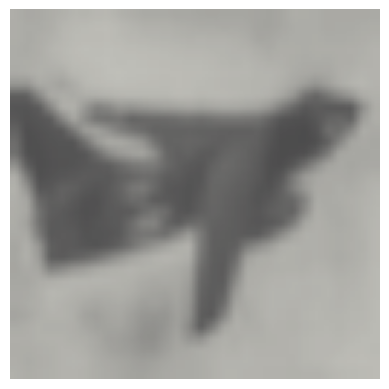

Top 16 Nearest Neighbors (in latent space)


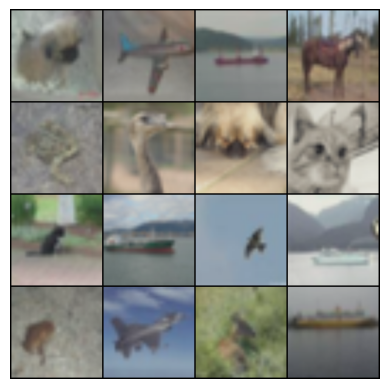

In [ ]:
display_nearest_neighbors('context_encoder', model, test_loader)

## Demo 2: Rotation Prediction [[2]](https://arxiv.org/abs/1803.07728)

In this paper, the authors show that accurately predicting the degrees of rotation in images is a self-supervised learning task that learns good representations for downstream tasks.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

More specifically, the authors showed that training a common CNN architecture (AlexNet, ResNet) on the rotation task learns semantically interpretable convolutional masks similar to those learned in supervised learning.

### Example Code

In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class RotationPrediction(nn.Module):
    metrics = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__(self, dataset, n_classes):
        super().__init__()
        if dataset == 'cifar10':
            self.model = NetworkInNetwork()
            self.latent_dim = 192 * 8 * 8
            self.feat_layer = 'conv2'
        elif 'imagenet' in dataset:
            self.model = AlexNet()
            self.latent_dim = 256 * 13 * 13
            self.feat_layer = 'conv5'
        else:
            raise Exception('Unsupported dataset:', dataset)
        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        if self.dataset == 'cifar10':
            classifier = nn.Sequential(
                Flatten(),
                nn.BatchNorm1d(self.latent_dim, affine=False),
                nn.Linear(self.latent_dim, self.n_classes)
            )
        elif 'imagenet' in self.dataset:
            classifier = nn.Sequential(
                nn.AdaptiveMaxPool2d((6, 6)),
                nn.BatchNorm2d(256, affine=False),
                Flatten(),
                nn.Linear(256 * 6 * 6, self.n_classes)
            )
        else:
            raise Exception('Unsupported dataset:', dataset)
        return classifier

    def forward(self, images):
        batch_size = images.shape[0]
        images, targets = self._preprocess(images)
        targets = targets.to(images.get_device())

        logits, zs = self.model(images, out_feat_keys=('classifier', self.feat_layer))
        loss = F.cross_entropy(logits, targets)

        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0] * 100.

        return dict(Loss=loss, Acc1=acc), zs[:batch_size]

    def encode(self, images):
        zs = self.model(images, out_feat_keys=(self.feat_layer,))
        return zs

    def _preprocess(self, images):
        batch_size = images.shape[0]
        images_90 = torch.flip(images.transpose(2, 3), (2,))
        images_180 = torch.flip(images, (2, 3))
        images_270 = torch.flip(images, (2,)).transpose(2, 3)
        images_batch = torch.cat((images, images_90, images_180, images_270), dim=0)
        targets = torch.arange(4).long().repeat(batch_size)
        targets = targets.view(batch_size, 4).transpose(0, 1)
        targets = targets.contiguous().view(-1)
        return images_batch, targets

### Linear Classification
We can use the feature maps in the later convolutional layers of the pretrained model as our learned representation for linear classification.

In [ ]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('rotation')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 79.564, Top 5 Accuracy: 99.136

Test Set
Top 1 Accuracy: 79.91, Top 5 Accuracy: 99.12



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


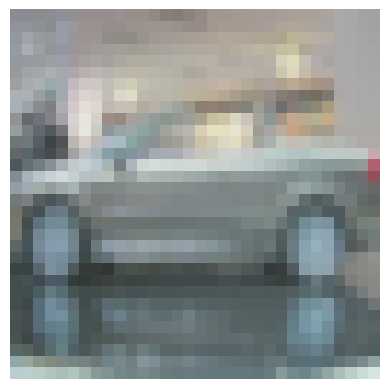

Top 16 Nearest Neighbors (in latent space)


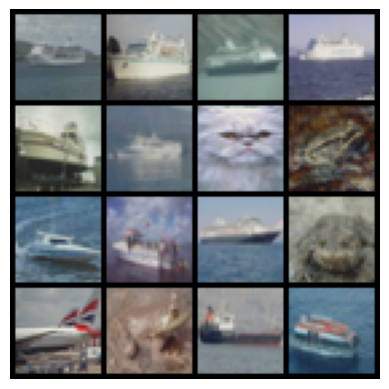

Image 2


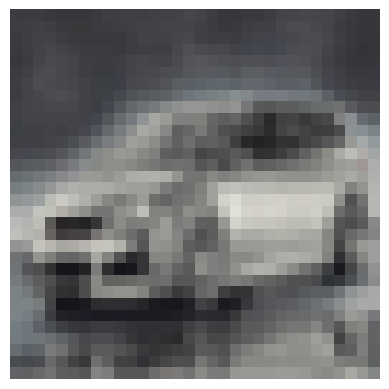

Top 16 Nearest Neighbors (in latent space)


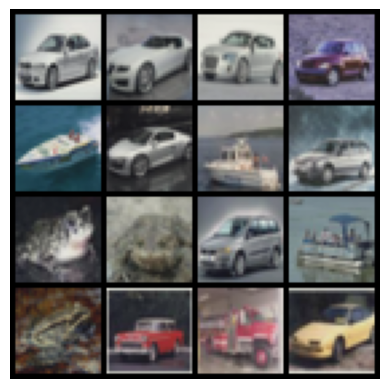

Image 3


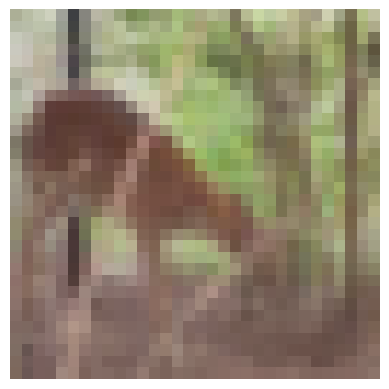

Top 16 Nearest Neighbors (in latent space)


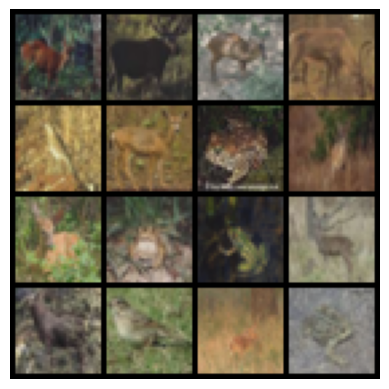

Image 4


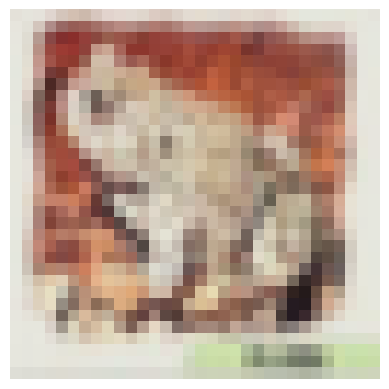

Top 16 Nearest Neighbors (in latent space)


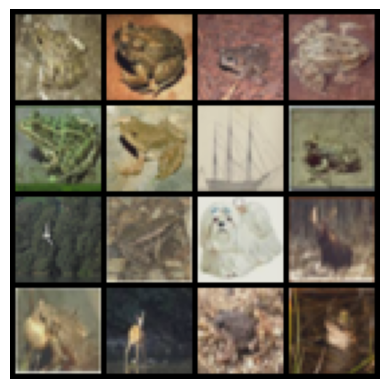

In [ ]:
display_nearest_neighbors('rotation', model, test_loader)

## Demo 3: SimCLR [[3]](https://arxiv.org/abs/2002.05709)

SimCLR is a contrastive learning framework to learn strong visual representations. An image $x$ is processed using data augmentation to produce two variants $x_i$ and $x_j$ which are both fed into encoder $f$ (a CNN) and projection head $g$ (a small MLP). The models optimize a contrastive loss to maximally align projected latents $z_i, z_j$. We consider $x_i, x_j$ as a positive pair, and any other $x_i, x_k$ pairs (i.e. different images in the same batch) are negative pairs. A visual diagram of the training procedure is shown below (from the paper).

![](https://drive.google.com/uc?id=1XW1uIkUTMSa0DZncivSYXzM5gA5FIhF6)

More formally, the loss between positive example $z_i, z_j$ is:
$$\ell_{i,j} = -\log{\frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i, z_k)/\tau)}}$$
where $\text{sim}(z_i, z_j) = z_i^Tz_j / (\left\Vert z_i \right\Vert \left\Vert z_j \right\Vert)$. The loss function can also be interpreted as a standard cross entropy loss to classify positive samples where logits are constructed using a given similarity function.

Note: A common idea in contrastive learning methods is that a larger batch means more negative samples. Therefore, these methods usually benefit the most from large-batch learning compared to other self-supervised learning tasks.

### Example Code

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from deepul_helper.resnet import resnet_v1
from deepul_helper.batch_norm import SyncBatchNorm, BatchNorm1d

# Some code adapted from https://github.com/sthalles/SimCLR
class SimCLR(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes, dist=None):
        super().__init__()
        self.temperature = 0.5
        self.projection_dim = 128

        if dataset == 'cifar10':
            resnet = resnet_v1((3, 32, 32), 50, 1, cifar_stem=True)
            resnet = SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048
        elif 'imagenet' in dataset:
            resnet = resnet_v1((3, 128, 128), 50, 1, cifar_stem=False)
            if dist is not None:
                resnet = nn.SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048

        self.proj = nn.Sequential(
            nn.Linear(self.latent_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim, center=False)
        )

        self.dataset = dataset
        self.n_classes = n_classes
        self.dist = dist

    def construct_classifier(self):
        return nn.Sequential(nn.Linear(self.latent_dim, self.n_classes))

    def forward(self, images):
        n = images[0].shape[0]
        xi, xj = images
        hi, hj = self.encode(xi), self.encode(xj) # (N, latent_dim)
        zi, zj = self.proj(hi), self.proj(hj) # (N, projection_dim)
        zi, zj = F.normalize(zi), F.normalize(zj)

        # Each training example has 2N - 2 negative samples
        # 2N total samples, but exclude the current and positive sample

        if self.dist is None:
            zis = [zi]
            zjs = [zj]
        else:
            zis = [torch.zeros_like(zi) for _ in range(self.dist.get_world_size())]
            zjs = [torch.zeros_like(zj) for _ in range(self.dist.get_world_size())]

            self.dist.all_gather(zis, zi)
            self.dist.all_gather(zjs, zj)

        z1 = torch.cat((zi, zj), dim=0) # (2N, projection_dim)
        z2 = torch.cat(zis + zjs, dim=0) # (2N * n_gpus, projection_dim)

        sim_matrix = torch.mm(z1, z2.t()) # (2N, 2N * n_gpus)
        sim_matrix = sim_matrix / self.temperature
        # Mask out same-sample terms
        n_gpus = 1 if self.dist is None else self.dist.get_world_size()
        rank = 0 if self.dist is None else self.dist.get_rank()
        sim_matrix[torch.arange(n), torch.arange(rank*n, (rank+1)*n)]  = -float('inf')
        sim_matrix[torch.arange(n, 2*n), torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n)] = -float('inf')

        targets = torch.cat((torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n),
                             torch.arange(rank*n, (rank+1)*n)), dim=0)
        targets = targets.to(sim_matrix.get_device()).long()

        loss = F.cross_entropy(sim_matrix, targets, reduction='sum')
        loss = loss / n
        return dict(Loss=loss), hi

    def encode(self, images):
        return self.resnet(images[0])

    def get_features(self, images):
        return self.resnet.get_features(images)


### Linear Classification
We can use the encoded vector $h_i$ as our latent representation.

In [ ]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('simclr')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 90.094, Top 5 Accuracy: 99.46

Test Set
Top 1 Accuracy: 92.84, Top 5 Accuracy: 99.87



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


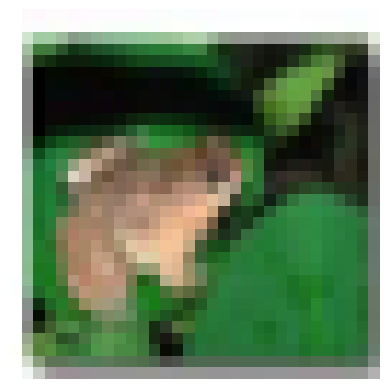

Top 16 Nearest Neighbors (in latent space)


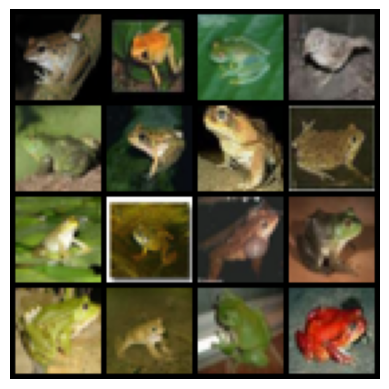

Image 2


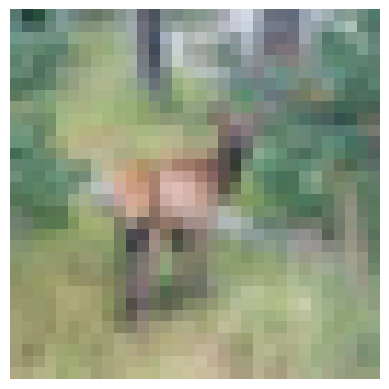

Top 16 Nearest Neighbors (in latent space)


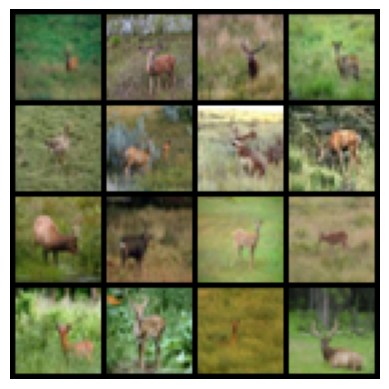

Image 3


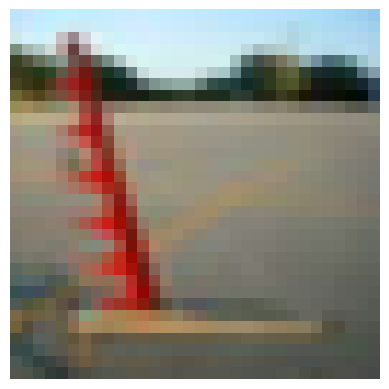

Top 16 Nearest Neighbors (in latent space)


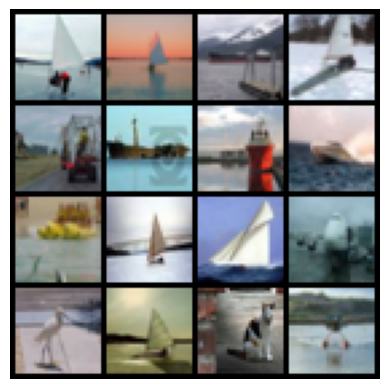

Image 4


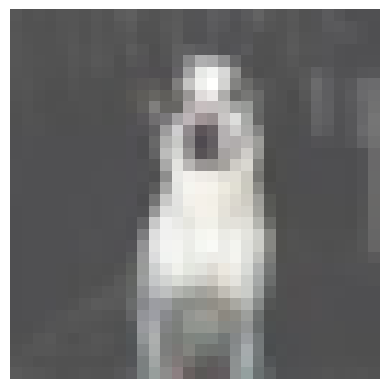

Top 16 Nearest Neighbors (in latent space)


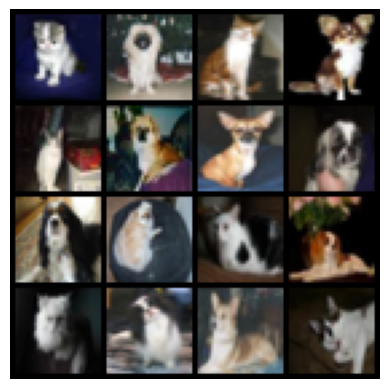

In [ ]:
display_nearest_neighbors('simclr', model, test_loader)

## Other Tasks
In addition to the above tasks, prior work has also investigated other self-superivsed tasks such as solving jigsaw puzzles [[4]](https://arxiv.org/abs/1603.09246), cycle-consistency [[5]](https://arxiv.org/abs/1903.07593), contrastive learning [[6]](https://arxiv.org/abs/1807.03748)[[7]](https://arxiv.org/abs/1905.09272)[[8]](https://arxiv.org/abs/1906.05849)[[9]](https://arxiv.org/abs/1911.05722), and patch prediction [[10]](https://arxiv.org/abs/1505.05192). See [here](https://github.com/jason718/awesome-self-supervised-learning) for a great resource on more self-supervised learning papers.

# Demo 4: Using Representations for Downstream Tasks

After pretraining a model on a self-supervised learning task, we can use it for other downstream tasks. In this demo, we use the pre-trained ResNet50 backbone from training SimCLR on a subset of ImageNet to learn a semantic segmentation model on Pascal VOC 2012. We use a simple U-Net [[11]](https://arxiv.org/abs/1505.04597) architecture with skip connections across feature maps between the SimCLR encoder and learned upsampling decoder. We do not fine-tune the SimCLR ResNet50 backbone, and only optimize the upsampling portion.

![](https://drive.google.com/uc?id=19dxxcwof0IA0jyv0VCl4rnZZf3ajA22s)

The training script can be found in `train_segmentation.py` [here](https://github.com/wilson1yan/cs294-158-ssl/blob/master/train_segmentation.py).

## Example Code

In [ ]:
# Code adapted from https://github.com/qubvel/segmentation_models.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from deepul_helper.resnet import NormReLU

class SegmentationModel(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, n_classes):
        super().__init__()

        decoder_channels = (512, 256, 128, 64, 32)
        encoder_channels = (2048, 1024, 512, 256, 64) # Starting from head (resnet 50)

        # Construct decoder blocks
        in_channels = [encoder_channels[0]] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.dec_blocks = nn.ModuleList(blocks)

        # Segmentation head for output prediction
        self.seg_head = nn.Conv2d(decoder_channels[-1], n_classes, kernel_size=3, padding=1)

    def forward(self, features, targets):
        features = features[1:] # remove first skip with same spatial resolution
        features = features[::-1] # reverse channels to start from head of encoder

        skips = features[1:]
        x = features[0]
        for i, decoder_block in enumerate(self.dec_blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        logits = self.seg_head(x)
        loss = F.cross_entropy(logits, targets)

        return dict(Loss=loss), logits


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            skip_channels,
            out_channels,
    ):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels,
                      kernel_size=3, padding=1),
            NormReLU((out_channels, None, None)), # only care about channel dim for BN
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            NormReLU((out_channels, None, None))
        )

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

## Segmentation Results
Below, we show a random subset of segmentations from the trained model. Every set of 3 images consists of the original image, the labeled segmentation, and the predicted segmentation.

Using downloaded and verified file: data\pascalvoc2012\VOCtrainval_11-May-2012.tar
Extracting data\pascalvoc2012\VOCtrainval_11-May-2012.tar to data\pascalvoc2012
Using downloaded and verified file: data\pascalvoc2012\VOCtrainval_11-May-2012.tar
Extracting data\pascalvoc2012\VOCtrainval_11-May-2012.tar to data\pascalvoc2012


c:\Users\utilisateur\Desktop\Cours\Analyse d'images\TP5\deepul_helper\demos.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(osp.join('results', 'imag

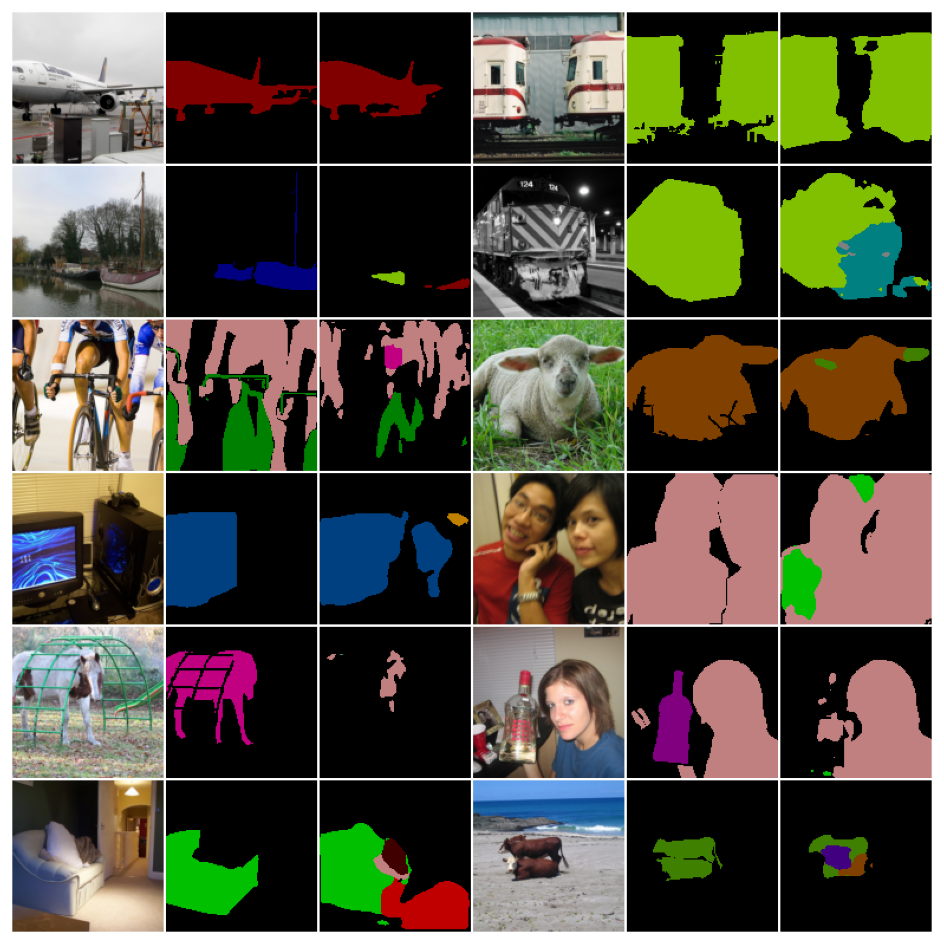

In [ ]:
from deepul_helper.demos import show_segmentation
show_segmentation()

# Demo 5: Avoiding Trivial Representations in Self-Supervised Tasks

When designing a self-supervised learning task, it is important to make sure that no trivial solutions exists. In general, a learned solution is trivial if the model is able to successfully complete its task by taking advantage of low-level features. As a result, it doesn't learn a good representation so downstream performance is bad.

For example, in the jigsaw [[4]](https://arxiv.org/abs/1603.09246) task, a model can "cheat" by just looking at the boundary textures of the jigsaw pieces, or following and matching straight lines across different pieces. These issues can generally be fixed by ranndom cropping, shifting, and spacially jittering.

We look at two other less obvious aspects of images that may reduce performance.

## Chromatic Aberration

Chromatic aberration occurs when the different focal lengths of light results in the light not meeting all at the same point.
![from wikipedia](https://drive.google.com/uc?id=1PYGoQWnH0aAeiE_8t4ef5WDcq1UIQQ5t)

A example of very apparent chromatic aberration is shown below, where the green and magenta colors are clearly offset with each other:

![](https://drive.google.com/uc?id=1M1B6kV6ddBwyJse3FQT8_XBTeqs5s5WL)

Chromatic aberration generally becomes a problem in patch-based self-supervised learning tasks that design, such as solving jigsaw puzzles, or predicintg the correct location of a patch in an image In this case, the model can take advantage of the low-level chromatic aberration features to get a strong idea of where the patch is located without understanding the actual context.

Below is a quick demo of chromatic aberration in more realistic images, and possible fixes. Note that in general, chromatic aberration is fairly hard to spot with the naked eye, but deep learning models are still able to use it to their advantage.

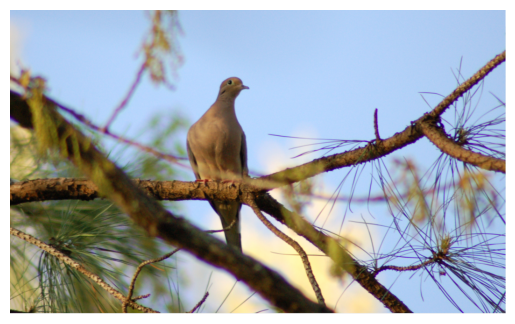

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# You can see some chromatic aberration in the purple fringes around the branches
path = ""
image = Image.open("C:\\Users\\utilisateur\\Desktop\\Cours\Analyse d'images\\TP5\\cs294-158-ssl-master\\sample_images\\chrom_ab_demo.png")
plt.figure()
plt.axis('off')
plt.imshow(image)
plt.show()

Chromatic aberration is generally fixed through conversion to grayscale, or color dropping. Color dropping works by dropping 2 of the color channels and replacing them with random noise uniform or Gaussian noise.

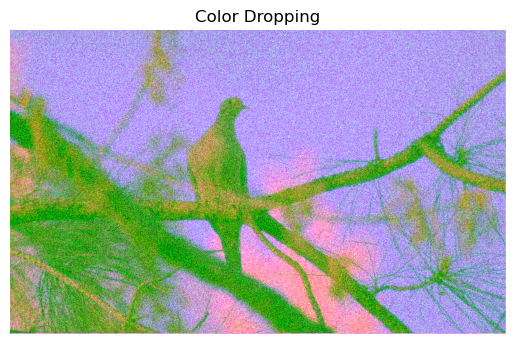

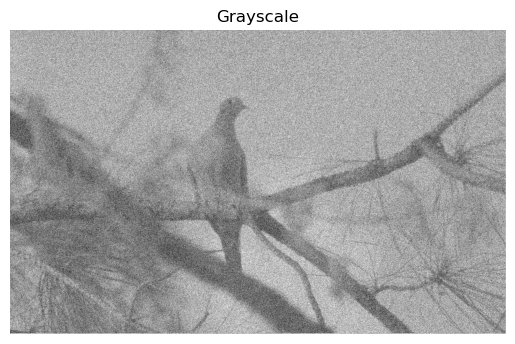

In [ ]:
import numpy as np

# Color Dropping
# We will drop all channels except R
image_cpy = image.copy()
pixels = image_cpy.load()

arr = np.array(image_cpy)
std_R = np.std(arr[:, :, 0])
mean_G, mean_B = np.mean(arr[:, :, 1]), np.mean(arr[:, :, 2])

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j] # (R, G, B, A)
    R, A = p[0], p[3]
    G = int(np.random.randn() * std_R + mean_G)
    B = int(np.random.randn() * std_R + mean_B)
    pixels[i, j] = (R, G, p[2], p[3])

plt.figure()
plt.title('Color Dropping')
plt.axis('off')
plt.imshow(image_cpy)
plt.show()

# Grayscale
image_cpy2 = image.copy()
pixels2 = image_cpy2.load()

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j]
    G = int(0.3 * p[0] + 0.59 * p[1] + 0.11 * p[2])
    pixels2[i, j] = (G, G, G, 255)

plt.figure()
plt.title('Grayscale')
plt.axis('off')
plt.imshow(image_cpy2)
plt.show()

## Color Intensity Histograms

In the SimCLR paper, the authors show that the histogram of color intensities of different patches within the same image have very similar histograms, which may degrade training by encouraging models to look at low-level (pixel intensity) features to solve self-supervised tasks that involve matching positive patches of the same image.

Below, we run a similar demo to what was demonstrated in the paper

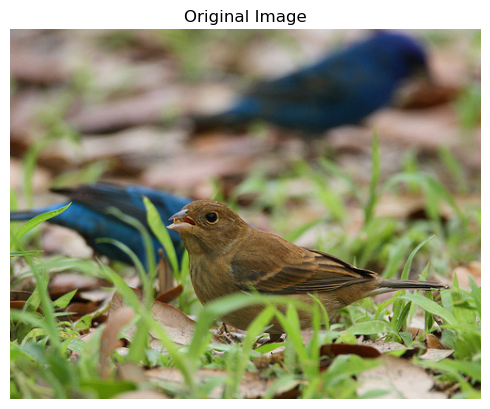

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

path = "C:\\Users\\utilisateur\\Desktop\\Cours\Analyse d'images\\TP5\\cs294-158-ssl-master\\sample_images\\n01537544_19414.JPEG"
image = Image.open(path)
plt.figure()
plt.title('Original Image')
plt.axis('off')
plt.imshow(image)
plt.show()

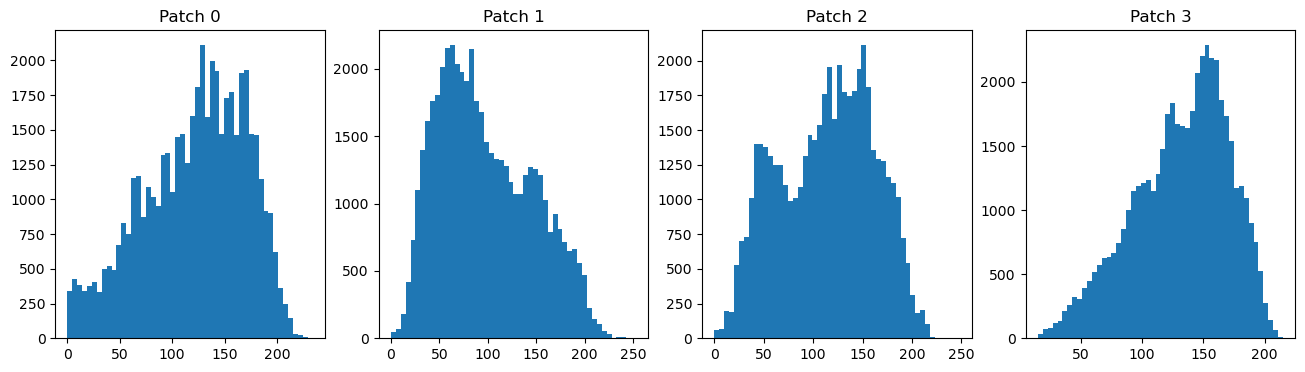

In [ ]:
import numpy as np
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

Now we apply color jittering to mitigate this effect

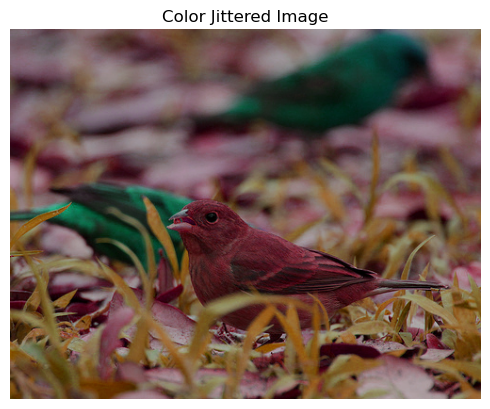

In [ ]:
from torchvision import transforms

color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
jitter_img = color_jitter(image)

image = Image.open(path)
plt.figure()
plt.title('Color Jittered Image')
plt.axis('off')
plt.imshow(jitter_img)
plt.show()

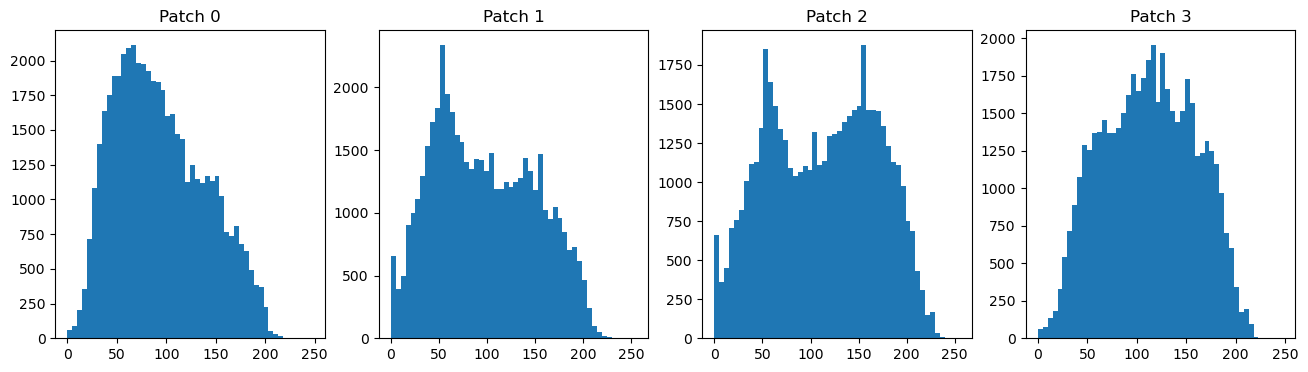

In [ ]:
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

Comparaison des peroformences de classification de l'ensemble des models 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from io import StringIO
import sys
from deepul_helper.demos import load_model_and_data, evaluate_accuracy


In [ ]:
model_names = ['context_encoder', 'rotation', 'simclr']
results = []

for model_name in tqdm(model_names, desc="Évaluation des modèles"):
    model, linear_classifier, train_loader, test_loader = load_model_and_data(model_name)
    
    # Redirection de la sortie pour capturer les résultats d'évaluation
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    
    # Évaluation du modèle (affichage capturé)
    evaluate_accuracy(model, linear_classifier, train_loader, test_loader)
    
    # Rétablir la sortie standard
    sys.stdout = old_stdout
    
    # Extraire les résultats de la sortie capturée
    output = mystdout.getvalue()
    
    # Initialiser les valeurs de précision
    train_accuracy = None
    test_accuracy = None
    
    # Extraire les précisions de la sortie capturée
    lines = output.splitlines()
    for i, line in enumerate(lines):
        if "Train Set" in line:
            next_line = lines[i + 1] if i + 1 < len(lines) else ""
            if "Top 1 Accuracy:" in next_line:
                train_accuracy = float(next_line.split(":")[1].strip().split(",")[0])
        elif "Test Set" in line:
            next_line = lines[i + 1] if i + 1 < len(lines) else ""
            if "Top 1 Accuracy:" in next_line:
                test_accuracy = float(next_line.split(":")[1].strip().split(",")[0])
    
    # Ajouter les résultats pour chaque modèle
    results.append({
        'Model': model_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })


Évaluation des modèles:   0%|          | 0/3 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


c:\Users\utilisateur\Desktop\Cours\Analyse d'images\TP5\deepul_helper\demos.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_pth, map_location='cp

Files already downloaded and verified
Files already downloaded and verified


Évaluation des modèles:  67%|██████▋   | 2/3 [01:21<00:41, 41.36s/it]

Files already downloaded and verified
Files already downloaded and verified


Évaluation des modèles: 100%|██████████| 3/3 [03:02<00:00, 60.74s/it]


Affichage des resultats pour comparaison DATA FRAME + GRAPHIQUE


In [ ]:
# Dataframe
import pandas as pd
df_results = pd.DataFrame(results)
styled_df = df_results.style.set_caption("Comparaison des Performances de Classification des Modèles") \
                             .format({"Train Accuracy": "{:.2f}%", "Test Accuracy": "{:.2f}%"}) \
                             .highlight_max(color="lightgreen", subset=["Train Accuracy", "Test Accuracy"]) \
                             .highlight_min(color="lightcoral", subset=["Train Accuracy", "Test Accuracy"])
styled_df

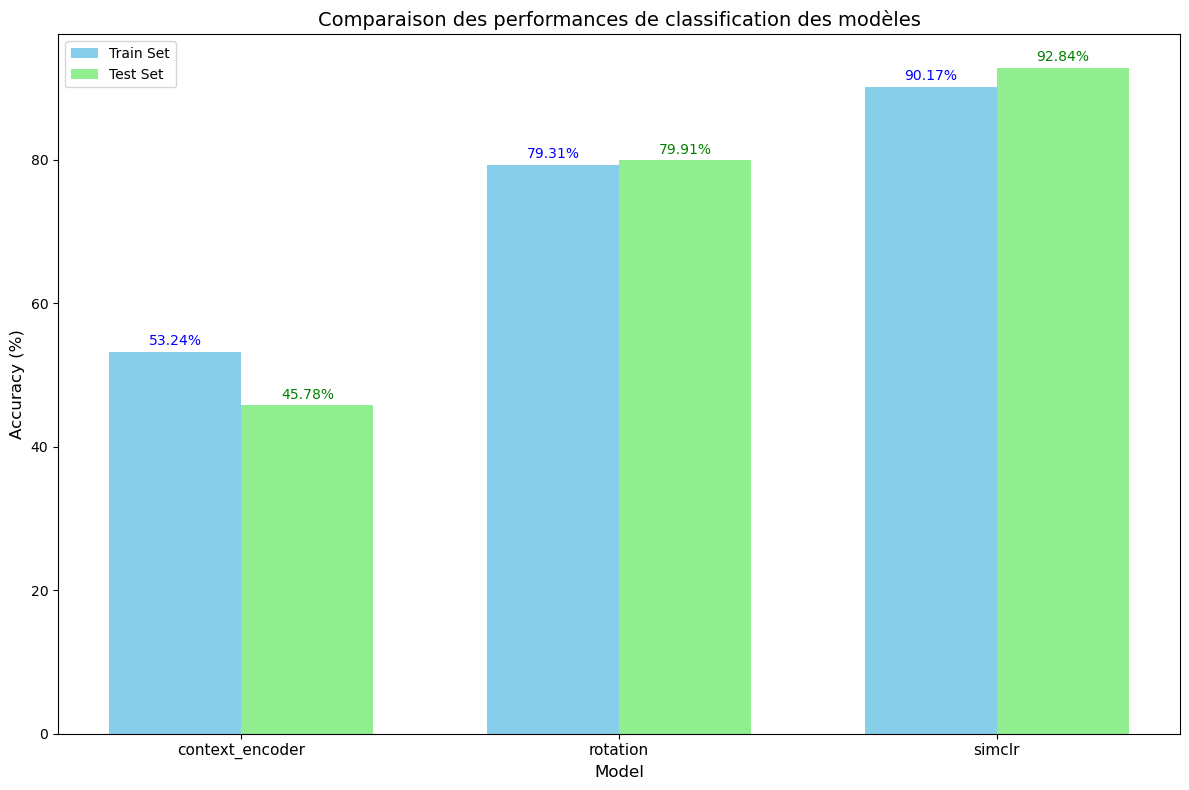

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



bar_width = 0.35
index = np.arange(len(df_results['Model']))


plt.figure(figsize=(12, 8))
train_bars = plt.bar(index - bar_width / 2, df_results['Train Accuracy'], bar_width, color='skyblue', label='Train Set')
test_bars = plt.bar(index + bar_width / 2, df_results['Test Accuracy'], bar_width, color='lightgreen', label='Test Set')

for bar in train_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, color='blue')
for bar in test_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, color='green')

plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Comparaison des performances de classification des modèles', fontsize=14)
plt.xticks(index, df_results['Model'], fontsize=11)
plt.legend()
plt.tight_layout()
plt.show()


Parmi les trois modèles, SimCLR est le plus performant, avec des précisions élevées sur les ensembles d'entraînement (90.16%) et de test (92.84%), ce qui démontre des représentations robustes et bien généralisées. Le modèle Rotation montre une stabilité notable, avec des précisions similaires en entraînement (79.60%) et en test (79.91%), indiquant une bonne robustesse sans surapprentissage. En revanche, Context Encoder affiche les performances les plus faibles (53.24% en entraînement et 45.78% en test), ce qui limite son utilité pour la classification.

Programme 1 : Context Encoder avec STL10
Inpainting Examples

Utilisation de l'appareil : cuda
Epoch [1/40], Loss: 0.0872, Accuracy: 0.3166
Epoch [2/40], Loss: 0.0369, Accuracy: 0.3970
Epoch [3/40], Loss: 0.0330, Accuracy: 0.4316
Epoch [4/40], Loss: 0.0311, Accuracy: 0.4506
Epoch [5/40], Loss: 0.0289, Accuracy: 0.4723
Epoch [6/40], Loss: 0.0278, Accuracy: 0.4830
Epoch [7/40], Loss: 0.0266, Accuracy: 0.4946
Epoch [8/40], Loss: 0.0258, Accuracy: 0.5050
Epoch [9/40], Loss: 0.0253, Accuracy: 0.5082
Epoch [10/40], Loss: 0.0244, Accuracy: 0.5201
Epoch [11/40], Loss: 0.0238, Accuracy: 0.5258
Epoch [12/40], Loss: 0.0228, Accuracy: 0.5373
Epoch [13/40], Loss: 0.0223, Accuracy: 0.5414
Epoch [14/40], Loss: 0.0219, Accuracy: 0.5459
Epoch [15/40], Loss: 0.0212, Accuracy: 0.5531
Epoch [16/40], Loss: 0.0207, Accuracy: 0.5594
Epoch [17/40], Loss: 0.0200, Accuracy: 0.5696
Epoch [18/40], Loss: 0.0199, Accuracy: 0.5691
Epoch [19/40], Loss: 0.0192, Accuracy: 0.5776
Epoch [20/40], Loss: 0.0183, Accuracy: 0.5878
Epoch [21/40], Loss: 0.0177, Accuracy: 0.5966
Epoch [22/

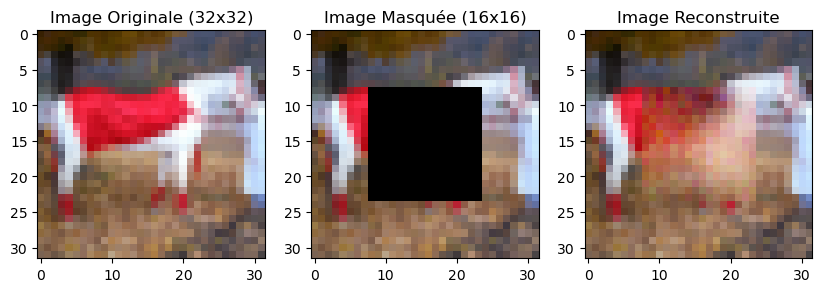

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import transforms
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil : {device}")

class SmallSTL10ContextEncoder(nn.Module):
    def __init__(self):
        super(SmallSTL10ContextEncoder, self).__init__()
        self.latent_dim = 400  

       
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, self.latent_dim, 4)         
        )

        # Décodeur pour reconstruire une zone de 16x16
        self.decoder = nn.Sequential(
            nn.BatchNorm2d(self.latent_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(self.latent_dim, 256, 4),    
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),     
            nn.Tanh()
        )

    def forward(self, images):
    
        images_center = images[:, :, 8:24, 8:24].clone()  
        images_masked = images.clone()
        images_masked[:, :, 8:24, 8:24] = 0              

      
        z = self.encoder(images_masked)
        center_recon = self.decoder(z)  

    
        images_reconstructed = images_masked.clone()
        images_reconstructed[:, :, 8:24, 8:24] = center_recon[:, :, 8:24, 8:24]  
        return F.mse_loss(center_recon[:, :, 8:24, 8:24], images_center), images_reconstructed, images_center, center_recon[:, :, 8:24, 8:24]
def train_context_encoder(model, data_loader, num_epochs=20, learning_rate=0.0001, threshold=0.1):
    model.to(device) 
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0
        for images, _ in data_loader:
            images = images.to(device) 
            optimizer.zero_grad()
            loss, _, images_center, center_recon = model(images)
            
            # Calcul de l'accuracy
            accuracy = ((torch.abs(center_recon - images_center) < threshold).float().mean()).item()
            total_accuracy += accuracy
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(data_loader)
        avg_accuracy = total_accuracy / len(data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")
def show_context_encoder_inpainting(model, data_loader):
    model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            loss, reconstructions, images_center, center_recon = model(images)
            threshold = 0.1
            accuracy = ((torch.abs(center_recon - images_center) < threshold).float().mean()).item()
            print(f"Accuracy for displayed batch: {accuracy:.4f}")
            images = images.cpu()
            masked_image = images.clone()
            masked_image[:, :, 8:24, 8:24] = 0
            reconstructions = reconstructions.cpu()
            fig, ax = plt.subplots(1, 3, figsize=(10, 4))
            ax[0].imshow(images[0].permute(1, 2, 0))
            ax[0].set_title("Image Originale (32x32)")
            
            ax[1].imshow(masked_image[0].permute(1, 2, 0))
            ax[1].set_title("Image Masquée (16x16)")

            ax[2].imshow(reconstructions[0].permute(1, 2, 0))
            ax[2].set_title("Image Reconstruite")
            plt.show()
            break
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip()
])

train_data = STL10(root='.', split='train', download=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
model = SmallSTL10ContextEncoder()
train_context_encoder(model, train_loader, num_epochs=40, learning_rate=0.0001)
show_context_encoder_inpainting(model, train_loader)


Utilisation de l'appareil : cuda
Epoch [1/40], Loss: 0.0632, Train Accuracy: 0.3113
Test Accuracy: 0.3529
Epoch [2/40], Loss: 0.0382, Train Accuracy: 0.3798
Test Accuracy: 0.4232
Epoch [3/40], Loss: 0.0334, Train Accuracy: 0.4240
Test Accuracy: 0.4214
Epoch [4/40], Loss: 0.0318, Train Accuracy: 0.4412
Test Accuracy: 0.4474
Epoch [5/40], Loss: 0.0303, Train Accuracy: 0.4585
Test Accuracy: 0.4567
Epoch [6/40], Loss: 0.0286, Train Accuracy: 0.4762
Test Accuracy: 0.4935
Epoch [7/40], Loss: 0.0276, Train Accuracy: 0.4911
Test Accuracy: 0.4747
Epoch [8/40], Loss: 0.0270, Train Accuracy: 0.4982
Test Accuracy: 0.4909
Epoch [9/40], Loss: 0.0262, Train Accuracy: 0.5067
Test Accuracy: 0.5074
Epoch [10/40], Loss: 0.0259, Train Accuracy: 0.5135
Test Accuracy: 0.4817
Epoch [11/40], Loss: 0.0257, Train Accuracy: 0.5138
Test Accuracy: 0.4977
Epoch [12/40], Loss: 0.0256, Train Accuracy: 0.5128
Test Accuracy: 0.5094
Epoch [13/40], Loss: 0.0245, Train Accuracy: 0.5281
Test Accuracy: 0.5264
Epoch [14/40],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012750106..0.9053043].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.060848225..0.9996733].


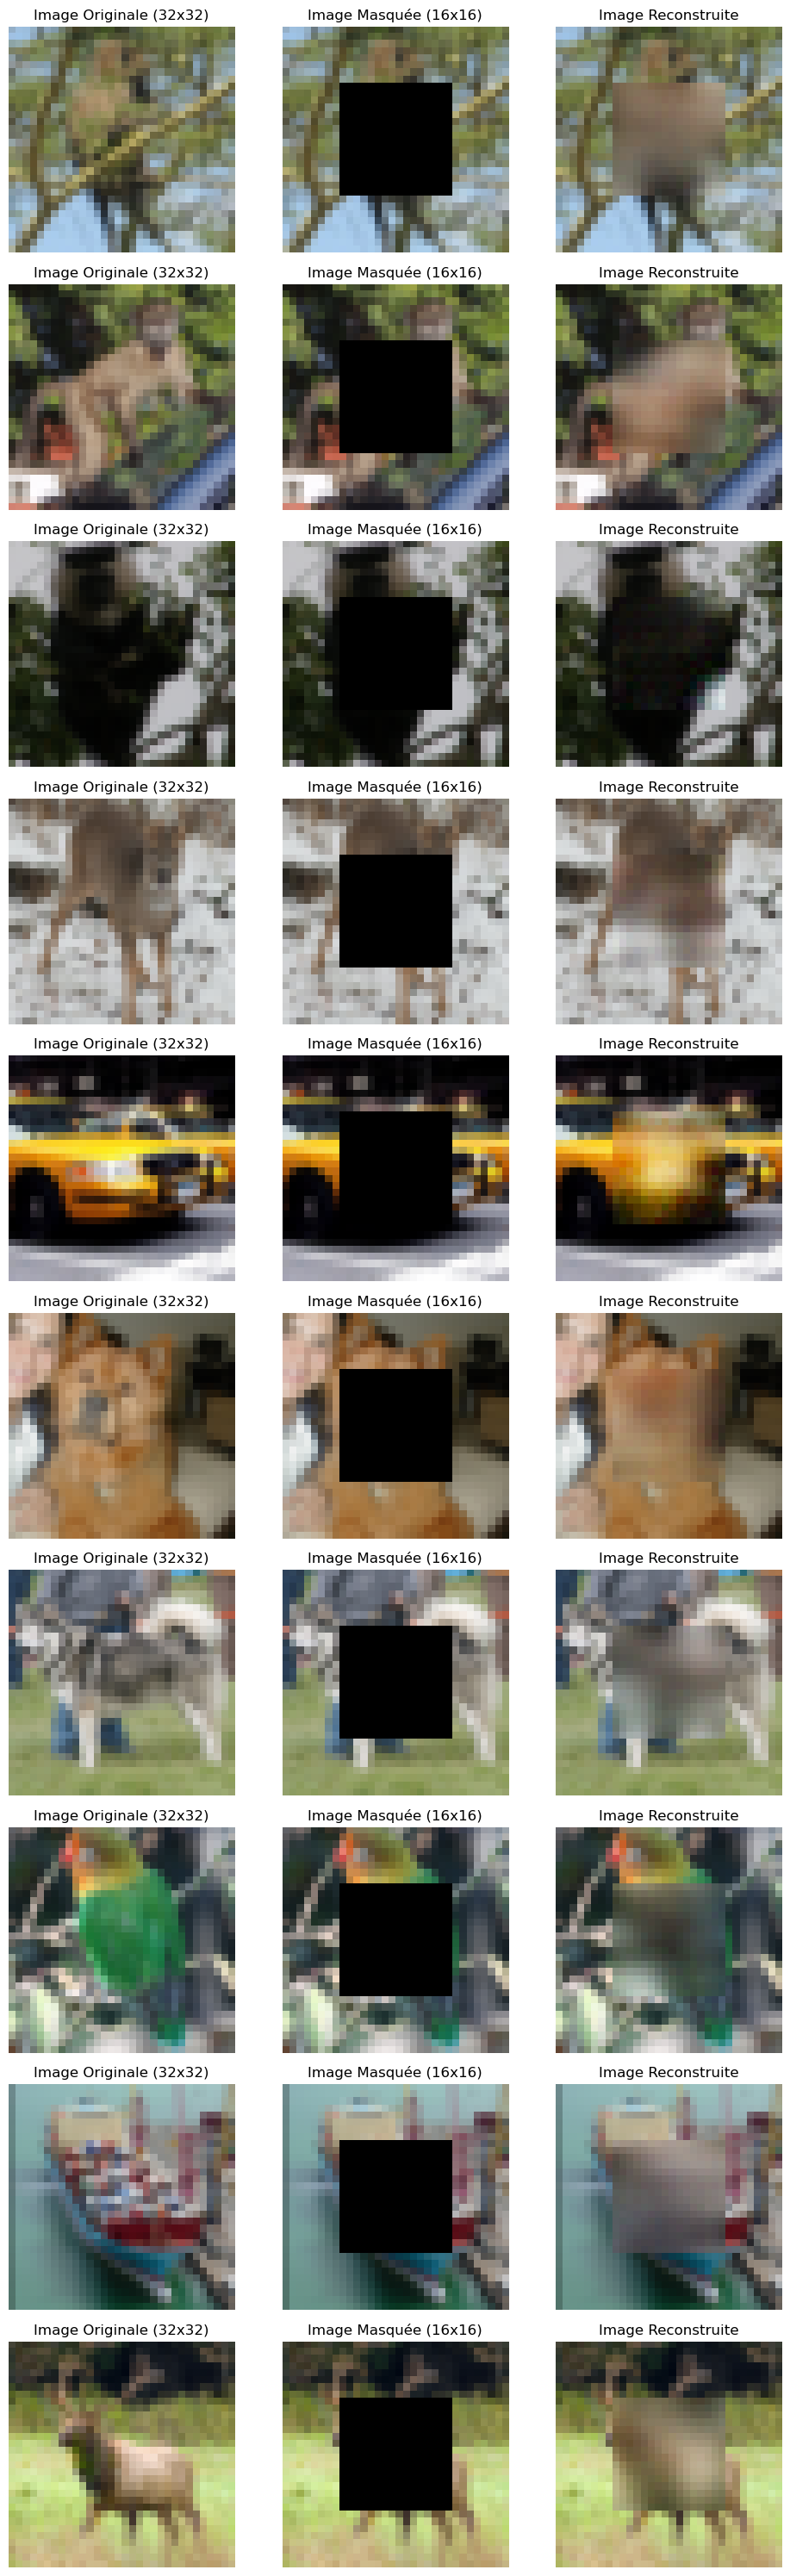

In [ ]:
class SmallSTL10ContextEncoder(nn.Module):
    def __init__(self):
        super(SmallSTL10ContextEncoder, self).__init__()
        self.latent_dim = 400 

        # Encodeur simple pour les images 32x32
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, self.latent_dim, 4)          
        )

        # Décodeur 
        self.decoder = nn.Sequential(
            nn.BatchNorm2d(self.latent_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(self.latent_dim, 256, 4),  
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),     
            nn.Tanh()
        )

    def forward(self, images):
        # Masquage de la région centrale pour les images 32x32
        images_center = images[:, :, 8:24, 8:24].clone()  
        images_masked = images.clone()
        images_masked[:, :, 8:24, 8:24] = 0              


        z = self.encoder(images_masked)
        center_recon = self.decoder(z)  

        # Reconstruction complète de l'image
        images_reconstructed = images_masked.clone()
        images_reconstructed[:, :, 8:24, 8:24] = center_recon[:, :, 8:24, 8:24]  # Remplace uniquement la zone centrale
        return F.mse_loss(center_recon[:, :, 8:24, 8:24], images_center), images_reconstructed, images_center, center_recon[:, :, 8:24, 8:24]


def train_context_encoder(model, train_loader, test_loader, num_epochs=20, learning_rate=0.0001, threshold=0.1):
    model.to(device) 
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0
        for images, _ in train_loader:
            images = images.to(device)  
            optimizer.zero_grad()
            loss, _, images_center, center_recon = model(images)
            
            # Calcul de l'accuracy
            accuracy = ((torch.abs(center_recon - images_center) < threshold).float().mean()).item()
            total_accuracy += accuracy

            # Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_accuracy = total_accuracy / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        test_accuracy = evaluate_accuracy(model, test_loader, threshold)
        print(f"Test Accuracy: {test_accuracy:.4f}")
def evaluate_accuracy(model, data_loader, threshold=0.1):
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            _, _, images_center, center_recon = model(images)
            accuracy = ((torch.abs(center_recon - images_center) < threshold).float().mean()).item()
            total_accuracy += accuracy
    avg_accuracy = total_accuracy / len(data_loader)
    return avg_accuracy
def show_context_encoder_inpainting(model, data_loader, num_examples=10):
    model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device) 
            _, reconstructions, _, _ = model(images)
            images = images.cpu()
            reconstructions = reconstructions.cpu()
            
            fig, axes = plt.subplots(num_examples, 3, figsize=(10, num_examples * 3))
            for i in range(num_examples):
                # Image originale
                axes[i, 0].imshow(images[i].permute(1, 2, 0))
                axes[i, 0].set_title("Image Originale (32x32)")
                axes[i, 0].axis('off')
                
                # Image masquée
                masked_image = images[i].clone()
                masked_image[:, 8:24, 8:24] = 0
                axes[i, 1].imshow(masked_image.permute(1, 2, 0))
                axes[i, 1].set_title("Image Masquée (16x16)")
                axes[i, 1].axis('off')
                
                # Image reconstruite
                axes[i, 2].imshow(reconstructions[i].permute(1, 2, 0))
                axes[i, 2].set_title("Image Reconstruite")
                axes[i, 2].axis('off')
            
            plt.tight_layout()
            plt.show()
            break
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip()
])
train_data = STL10(root='.', split='train', download=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = STL10(root='.', split='test', download=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
model = SmallSTL10ContextEncoder()
train_context_encoder(model, train_loader, test_loader, num_epochs=40, learning_rate=0.001)
show_context_encoder_inpainting(model, train_loader, num_examples=10)


Linear Classification

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)
linear_classifier = LinearClassifier(3072, 10).to(device)
def train_linear_classifier(encoder, classifier, train_loader, test_loader, num_epochs=5):
    encoder.eval() 
    classifier.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) 

            with torch.no_grad():
                _, embeddings, _, _ = encoder(images) 
            embeddings = embeddings.view(embeddings.size(0), -1) 

            optimizer.zero_grad()
            outputs = classifier(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
        test_accuracy = evaluate_accuracy(encoder, classifier, test_loader)
        print(f"Test Accuracy: {test_accuracy:.2f}%")
def evaluate_accuracy(encoder, classifier, data_loader):
    encoder.eval()
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            _, embeddings, _, _ = encoder(images)  
            embeddings = embeddings.view(embeddings.size(0), -1) 
            outputs = classifier(embeddings)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return accuracy
model.to(device)
test_data = STL10(root='.', split='test', download=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
train_linear_classifier(model, linear_classifier, train_loader, test_loader, num_epochs=20)


Utilisation de l'appareil : cuda
Epoch 1/20, Loss: 2.0793, Train Accuracy: 23.68%
Test Accuracy: 27.11%
Epoch 2/20, Loss: 1.9346, Train Accuracy: 28.88%
Test Accuracy: 29.62%
Epoch 3/20, Loss: 1.8876, Train Accuracy: 31.46%
Test Accuracy: 33.73%
Epoch 4/20, Loss: 1.8556, Train Accuracy: 32.40%
Test Accuracy: 32.65%
Epoch 5/20, Loss: 1.8304, Train Accuracy: 33.64%
Test Accuracy: 30.55%
Epoch 6/20, Loss: 1.8179, Train Accuracy: 33.88%
Test Accuracy: 28.27%
Epoch 7/20, Loss: 1.8586, Train Accuracy: 32.84%
Test Accuracy: 33.52%
Epoch 8/20, Loss: 1.7973, Train Accuracy: 35.46%
Test Accuracy: 34.16%
Epoch 9/20, Loss: 1.7621, Train Accuracy: 36.26%
Test Accuracy: 32.30%
Epoch 10/20, Loss: 1.7711, Train Accuracy: 35.72%
Test Accuracy: 33.14%
Epoch 11/20, Loss: 1.7713, Train Accuracy: 36.82%
Test Accuracy: 33.26%
Epoch 12/20, Loss: 1.7613, Train Accuracy: 36.72%
Test Accuracy: 32.77%
Epoch 13/20, Loss: 1.7639, Train Accuracy: 37.10%
Test Accuracy: 33.24%
Epoch 14/20, Loss: 1.7451, Train Accurac

Nearest Neighbors

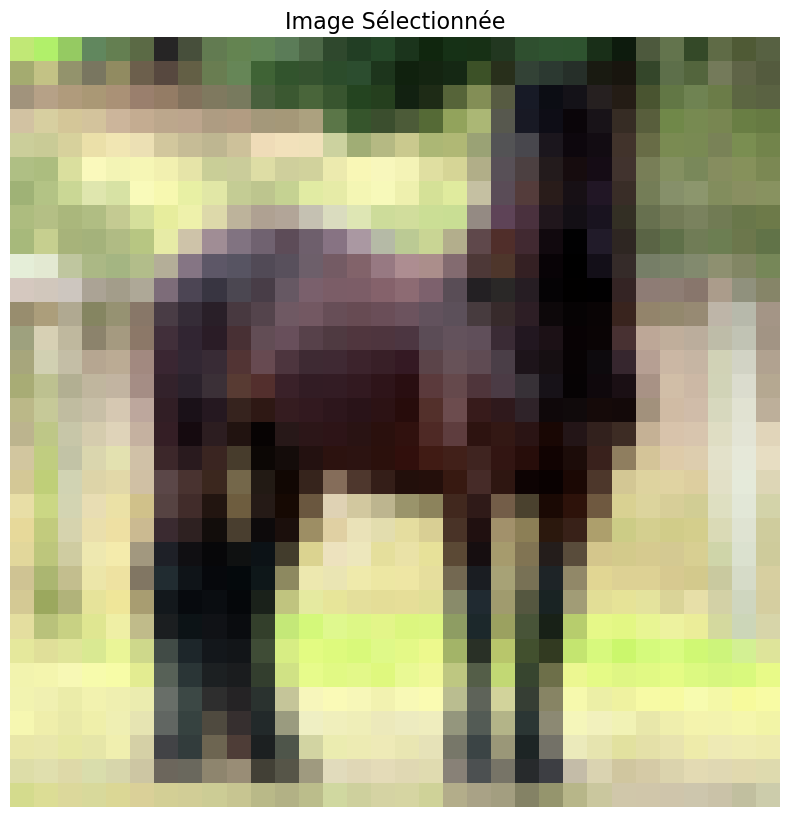

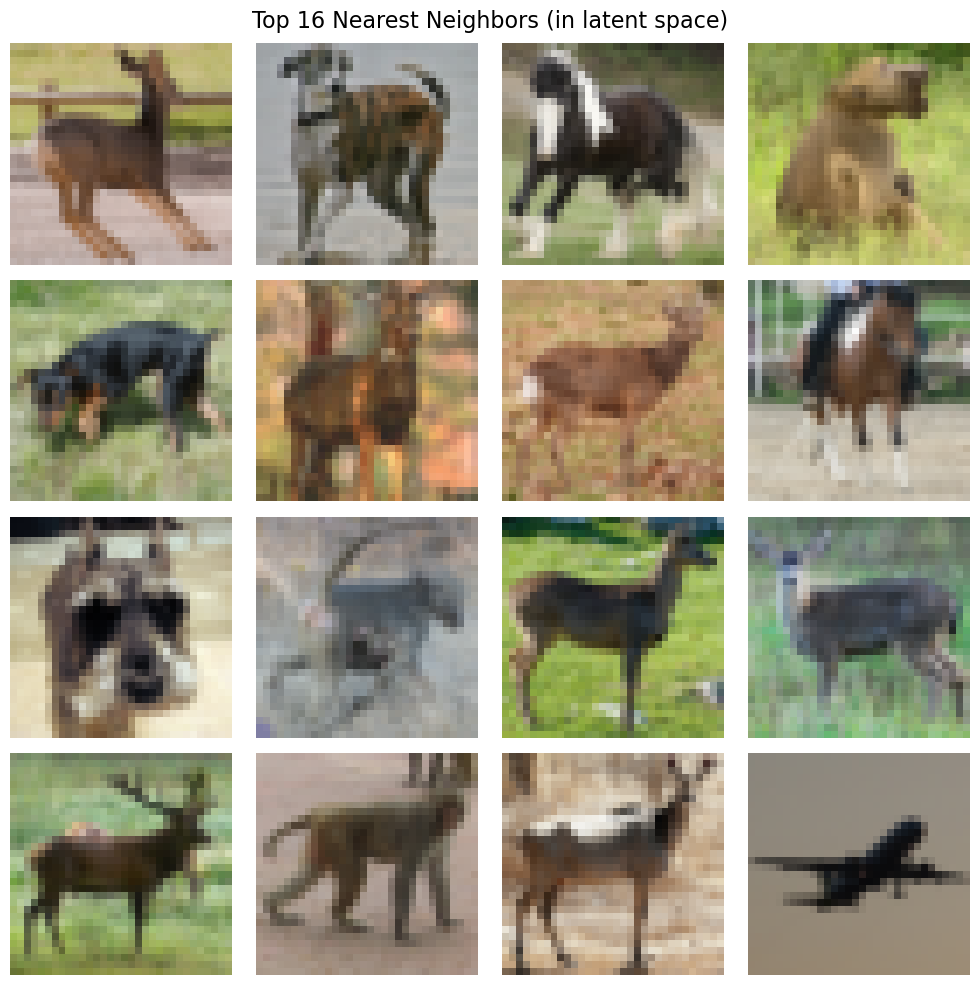

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import torch
import matplotlib.pyplot as plt

def display_nearest_neighbors(encoder, data_loader, n_neighbors=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.eval()
    
    embeddings = []
    images_list = []
    
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            embedded = encoder(images)[1] 
            embedded = embedded.view(embedded.size(0), -1) 
            embeddings.append(embedded.cpu())
            images_list.extend(images.cpu())  

    embeddings = torch.cat(embeddings).numpy()
    images_list = torch.stack(images_list)
    selected_index = np.random.choice(len(images_list))
    selected_embedding = embeddings[selected_index].reshape(1, -1)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(embeddings)
    distances, indices = nbrs.kneighbors(selected_embedding)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(images_list[selected_index].permute(1, 2, 0).numpy())
    ax.set_title("Image Sélectionnée", fontsize=16)
    ax.axis('off')
    plt.show()
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle("Top 16 Nearest Neighbors (in latent space)", fontsize=16)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images_list[indices[0, i + 1]].permute(1, 2, 0).numpy())
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
display_nearest_neighbors(model, train_loader)


Programme 2 : Rotation Prediction avec STL10
Linear Classification

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class RotationPredictionSTL10(nn.Module):
    def __init__(self):
        super(RotationPredictionSTL10, self).__init__()
        self.encoder = SmallSTL10ContextEncoder() 
        self.classifier = nn.Linear(400, 4)  
    def forward(self, images):
        batch_size = images.size(0)
        images, targets = self._preprocess(images)
        embeddings = self.encoder.encoder(images)
        embeddings = embeddings.view(embeddings.size(0), -1)
        logits = self.classifier(embeddings)
        
        loss = F.cross_entropy(logits, targets.to(device))
        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets.to(device)).float().sum()
        accuracy = correct / targets.shape[0] * 100.0

        return {"Loss": loss, "Acc1": accuracy}, embeddings[:batch_size]

    def _preprocess(self, images):
        batch_size = images.size(0)
        images_90 = torch.flip(images.transpose(2, 3), (2,))
        images_180 = torch.flip(images, (2, 3))
        images_270 = torch.flip(images, (2,)).transpose(2, 3)
        images_batch = torch.cat((images, images_90, images_180, images_270), dim=0)
        targets = torch.arange(4).long().repeat(batch_size).view(-1)
        return images_batch, targets
def train_rotation_prediction(model, train_loader, num_epochs=20, learning_rate=0.001):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        total_accuracy = 0.0

        for images, _ in train_loader:
            images = images.to(device)
            outputs, _ = model(images)
            loss = outputs["Loss"]
            accuracy = outputs["Acc1"]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_accuracy += accuracy.item()

        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_accuracy / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
])
train_data = STL10(root='.', split='train', download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
rotation_model = RotationPredictionSTL10()
train_rotation_prediction(rotation_model, train_loader, num_epochs=20, learning_rate=0.001)


Files already downloaded and verified
Epoch [1/20], Loss: 1.7264, Accuracy: 24.36%
Epoch [2/20], Loss: 1.4320, Accuracy: 24.68%
Epoch [3/20], Loss: 1.3938, Accuracy: 25.74%
Epoch [4/20], Loss: 1.3895, Accuracy: 25.29%
Epoch [5/20], Loss: 1.3880, Accuracy: 24.37%
Epoch [6/20], Loss: 1.3884, Accuracy: 25.23%
Epoch [7/20], Loss: 1.3888, Accuracy: 25.36%
Epoch [8/20], Loss: 1.3892, Accuracy: 25.88%
Epoch [9/20], Loss: 1.3896, Accuracy: 25.19%
Epoch [10/20], Loss: 1.3895, Accuracy: 24.89%
Epoch [11/20], Loss: 1.3885, Accuracy: 24.69%
Epoch [12/20], Loss: 1.3910, Accuracy: 24.14%
Epoch [13/20], Loss: 1.3931, Accuracy: 25.51%
Epoch [14/20], Loss: 1.3898, Accuracy: 25.43%
Epoch [15/20], Loss: 1.3888, Accuracy: 25.04%
Epoch [16/20], Loss: 1.3894, Accuracy: 24.58%
Epoch [17/20], Loss: 1.3906, Accuracy: 24.69%
Epoch [18/20], Loss: 1.3898, Accuracy: 24.53%
Epoch [19/20], Loss: 1.3932, Accuracy: 25.13%
Epoch [20/20], Loss: 1.3916, Accuracy: 25.78%


Nearest Neighbors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.006681192..1.0000001].


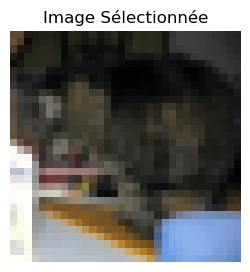

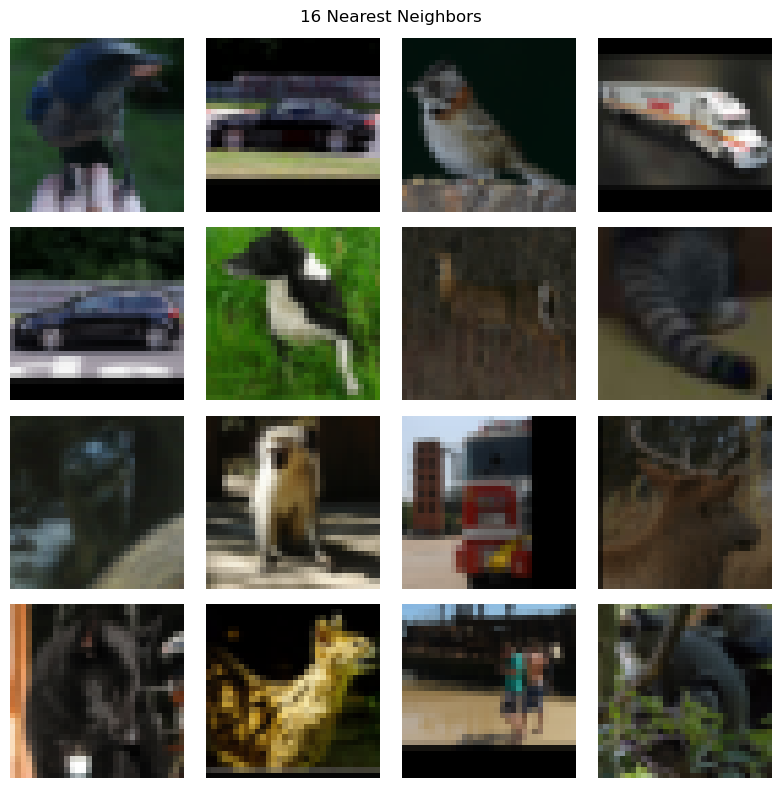

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import torch

def display_nearest_neighbors(encoder, data_loader, selected_index=0, n_neighbors=16):
    encoder.eval()
    embeddings = []
    images_list = []
    
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            embedded = encoder.encoder(images).view(images.size(0), -1)
            embeddings.append(embedded.cpu())
            images_list.extend(images.cpu())

    embeddings = torch.cat(embeddings).numpy()
    images_list = torch.stack(images_list)

    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(embeddings)
    distances, indices = nbrs.kneighbors([embeddings[selected_index]])
    plt.figure(figsize=(3, 3))
    plt.imshow(images_list[selected_index].permute(1, 2, 0))
    plt.title("Image Sélectionnée")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(8, 8))
    for i, idx in enumerate(indices[0][1:]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images_list[idx].permute(1, 2, 0))
        plt.axis("off")

    plt.suptitle("16 Nearest Neighbors")
    plt.tight_layout()
    plt.show()

display_nearest_neighbors(rotation_model.encoder, train_loader)


Linear Classification 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)
def train_linear_classifier(encoder, classifier, train_loader, test_loader, num_epochs=10):
    encoder.eval()
    classifier.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        classifier.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                embeddings = encoder.encoder(images).view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = classifier(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        train_accuracy = 100 * correct_train / total_train
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")


        classifier.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                embeddings = encoder.encoder(images).view(images.size(0), -1)
                outputs = classifier(embeddings)
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * correct_test / total_test
        print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {test_accuracy:.2f}%")

linear_classifier = LinearClassifier(400, 10).to(device)

# Préparer les données pour la classification
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip()
])

train_data = STL10(root='.', split='train', download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = STL10(root='.', split='test', download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Entraîner le classifieur linéaire
train_linear_classifier(rotation_model.encoder, linear_classifier, train_loader, test_loader, num_epochs=20)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Loss: 2.1831, Train Accuracy: 19.84%
Epoch [1/20], Test Accuracy: 23.45%
Epoch [2/20], Loss: 2.0993, Train Accuracy: 25.08%
Epoch [2/20], Test Accuracy: 25.55%
Epoch [3/20], Loss: 2.0577, Train Accuracy: 26.82%
Epoch [3/20], Test Accuracy: 27.85%
Epoch [4/20], Loss: 2.0358, Train Accuracy: 27.42%
Epoch [4/20], Test Accuracy: 27.84%
Epoch [5/20], Loss: 2.0174, Train Accuracy: 28.16%
Epoch [5/20], Test Accuracy: 27.88%
Epoch [6/20], Loss: 1.9930, Train Accuracy: 29.30%
Epoch [6/20], Test Accuracy: 28.62%
Epoch [7/20], Loss: 1.9817, Train Accuracy: 29.80%
Epoch [7/20], Test Accuracy: 30.31%
Epoch [8/20], Loss: 1.9663, Train Accuracy: 30.04%
Epoch [8/20], Test Accuracy: 30.29%
Epoch [9/20], Loss: 1.9563, Train Accuracy: 30.14%
Epoch [9/20], Test Accuracy: 30.14%
Epoch [10/20], Loss: 1.9433, Train Accuracy: 30.18%
Epoch [10/20], Test Accuracy: 30.73%
Epoch [11/20], Loss: 1.9364, Train Accuracy: 30.90%


Programme 3 : SimCLR avec STL10
SimCLR Model et Linear Classification

In [ ]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        self.projection_head = nn.Sequential(
            nn.Linear(base_model.fc.in_features, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        z = self.projection_head(h)
        return h, z

# Fonction de perte NT-Xent
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat((z_i, z_j), dim=0)
    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    sim_matrix = sim_matrix / temperature
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    mask = torch.eye(labels.shape[0], dtype=torch.bool)
    labels = labels[~mask].view(labels.shape[0], -1)
    sim_matrix = sim_matrix[~mask].view(sim_matrix.shape[0], -1)
    positives = sim_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = sim_matrix[~labels.bool()].view(sim_matrix.shape[0], -1)
    logits = torch.cat((positives, negatives), dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long)
    loss = F.cross_entropy(logits, labels)
    return loss

# Préparation des données
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=96),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = STL10(root='./data', split='unlabeled', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, drop_last=True)

# Initialisation du modèle et de l'optimiseur
base_model = resnet18(pretrained=False)
model = SimCLR(base_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraînement
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for (x_i, x_j), _ in train_loader:
        x_i, x_j = x_i.to(device), x_j.to(device)
        h_i, z_i = model(x_i)
        h_j, z_j = model(x_j)
        loss = nt_xent_loss(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Époque {epoch+1}/{num_epochs}, Perte : {total_loss/len(train_loader)}")


In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

linear_classifier = LinearClassifier().to(device)

5- Apprendre au modèle à prédire la position relative d’un patch de l’image relativement à un patch requête

Images chargées avec succès. Nombre d'images : 5000


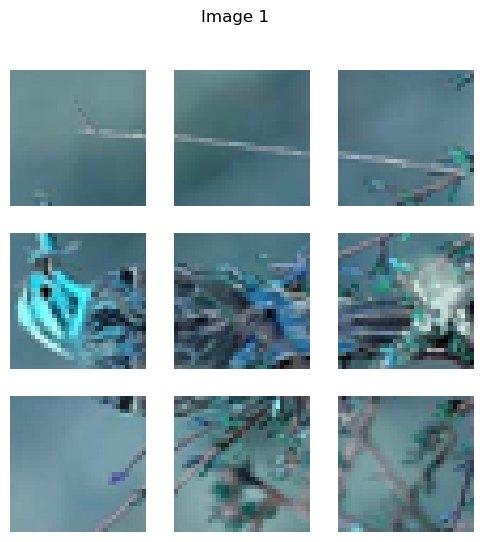

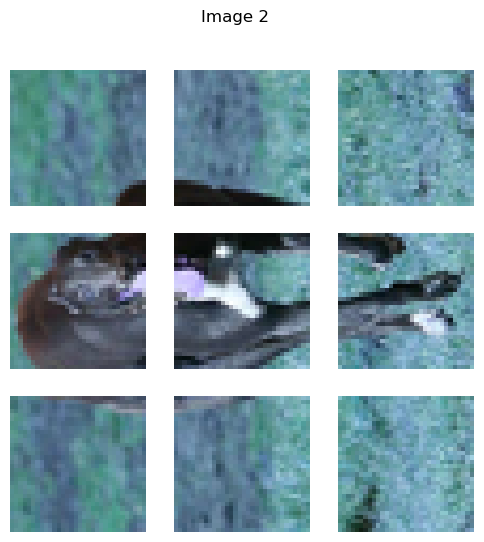

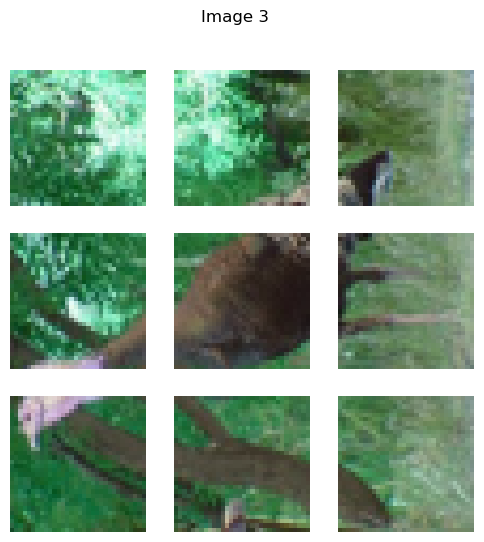

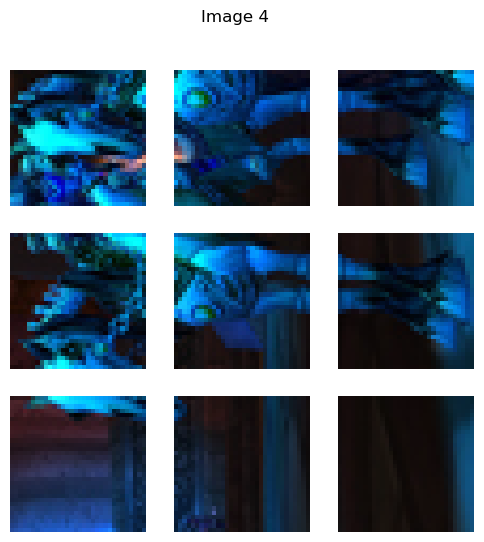

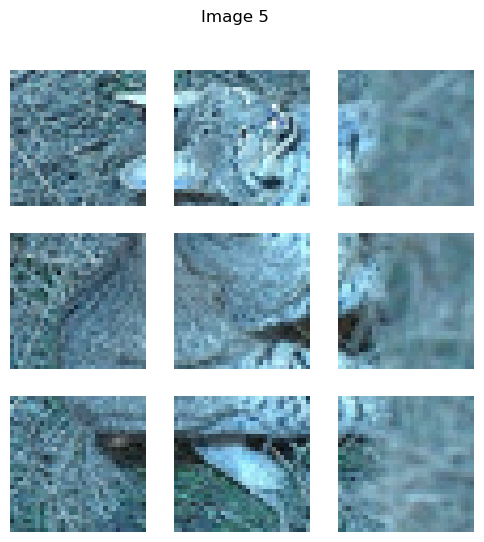

In [ ]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import urllib.request
import tarfile
data_dir = 'data/stl10_binary'
data_file = os.path.join(data_dir, 'train_X.bin')
url = "http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz"
output_file = "data/stl10_binary.tar.gz"
if not os.path.exists(data_file):
    if not os.path.exists(output_file):
        print("Téléchargement du fichier STL10 binaire...")
        urllib.request.urlretrieve(url, output_file)
        print("Téléchargement terminé.")
    
    if not os.path.exists(data_dir):
        print("Extraction du fichier STL10 binaire...")
        with tarfile.open(output_file, "r:gz") as tar:
            tar.extractall(path="data")
        print("Extraction terminée.")
    else:
        print("Les fichiers STL10 binaire existent déjà.")
def load_stl10_images(data_file, num_images=5000, image_size=96):
    with open(data_file, 'rb') as f:
        images = np.fromfile(f, dtype=np.uint8)
        if images.size != num_images * 3 * image_size * image_size:
            raise ValueError("Le fichier ne contient pas le nombre attendu de pixels pour {} images de taille {}x{}.".format(num_images, image_size, image_size))
        images = images.reshape((num_images, 3, image_size, image_size))
        images = np.transpose(images, (0, 2, 3, 1)) 
    print("Images chargées avec succès. Nombre d'images : {}".format(len(images)))
    return images

images = load_stl10_images(data_file)
if len(images) == 0:
    raise ValueError("Aucune image n'a été trouvée dans le fichier spécifié : {}".format(data_file))
# Définir le nombre de patches
n_patch = 9
n_rows, n_cols = 3, 3  # Diviser l'image en 3x3 parties

# Fonction pour diviser une image en patches
def split_image_to_patches(image, n_rows, n_cols):
    height, width, _ = image.shape
    patch_height, patch_width = height // n_rows, width // n_cols
    patches = []
    for i in range(n_rows):
        for j in range(n_cols):
            patch = image[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width]
            patches.append(patch)
    return patches

# Diviser plusieurs images en patches
num_images_to_process = 5
for img_idx in range(num_images_to_process):
    example_image = images[img_idx]
    patches = split_image_to_patches(example_image, n_rows, n_cols)

    # Afficher les patches
    plt.figure(figsize=(6, 6))
    plt.suptitle(f"Image {img_idx + 1}")
    for idx, patch in enumerate(patches):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

STL10

Epoch 1/20
23/23 [==============================] - 1s 21ms/step - loss: 3.4264 - accuracy: 0.0958 - val_loss: 3.3323 - val_accuracy: 0.1167
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 3.2621 - accuracy: 0.1139 - val_loss: 3.1861 - val_accuracy: 0.1111
Epoch 3/20
23/23 [==============================] - 0s 7ms/step - loss: 3.1243 - accuracy: 0.1361 - val_loss: 3.0599 - val_accuracy: 0.1000
Epoch 4/20
23/23 [==============================] - 0s 7ms/step - loss: 3.0074 - accuracy: 0.1264 - val_loss: 2.9538 - val_accuracy: 0.1111
Epoch 5/20
23/23 [==============================] - 0s 8ms/step - loss: 2.9080 - accuracy: 0.1194 - val_loss: 2.8664 - val_accuracy: 0.1056
Epoch 6/20
23/23 [==============================] - 0s 7ms/step - loss: 2.8286 - accuracy: 0.1167 - val_loss: 2.7920 - val_accuracy: 0.1556
Epoch 7/20
23/23 [==============================] - 0s 7ms/step - loss: 2.7569 - accuracy: 0.1486 - val_loss: 2.7330 - val_accuracy: 0.1056
Epoch 8/20
23/23 [=

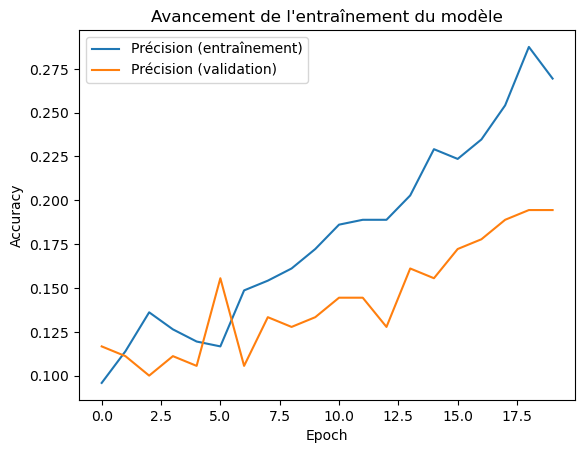

1/1 [==============================] - 0s 15ms/step


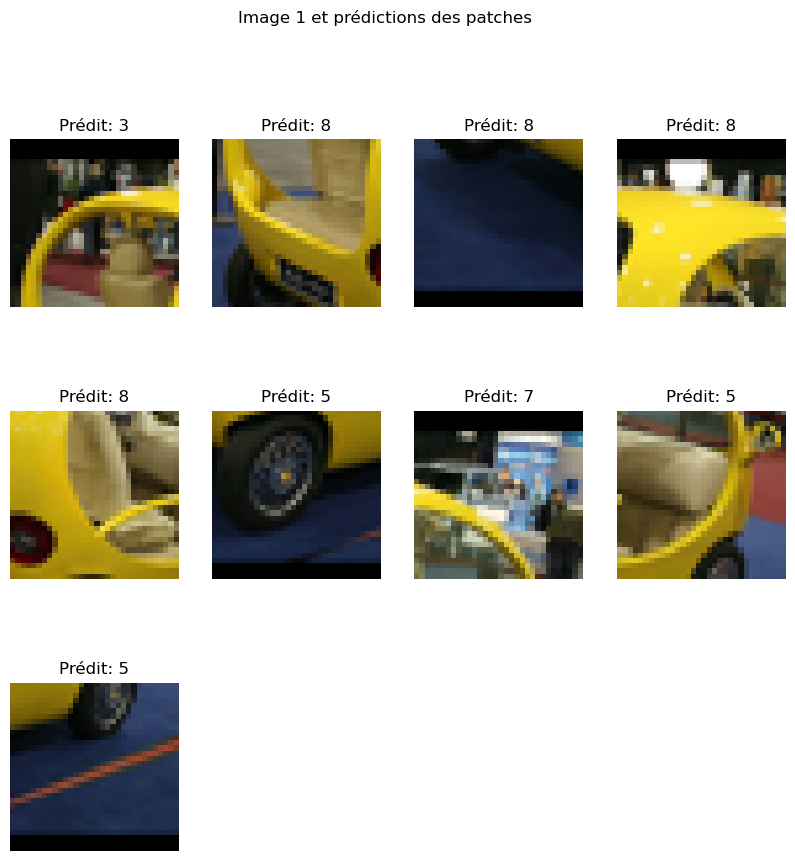

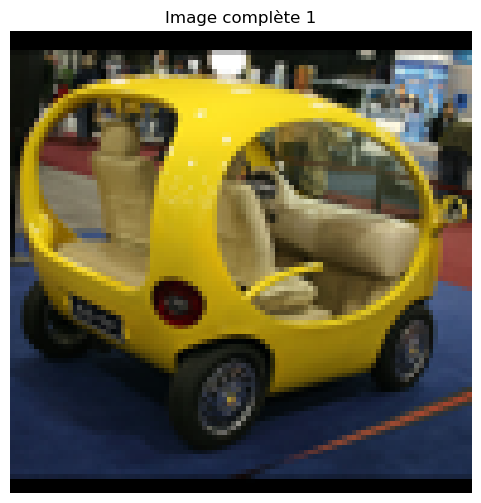

1/1 [==============================] - 0s 15ms/step


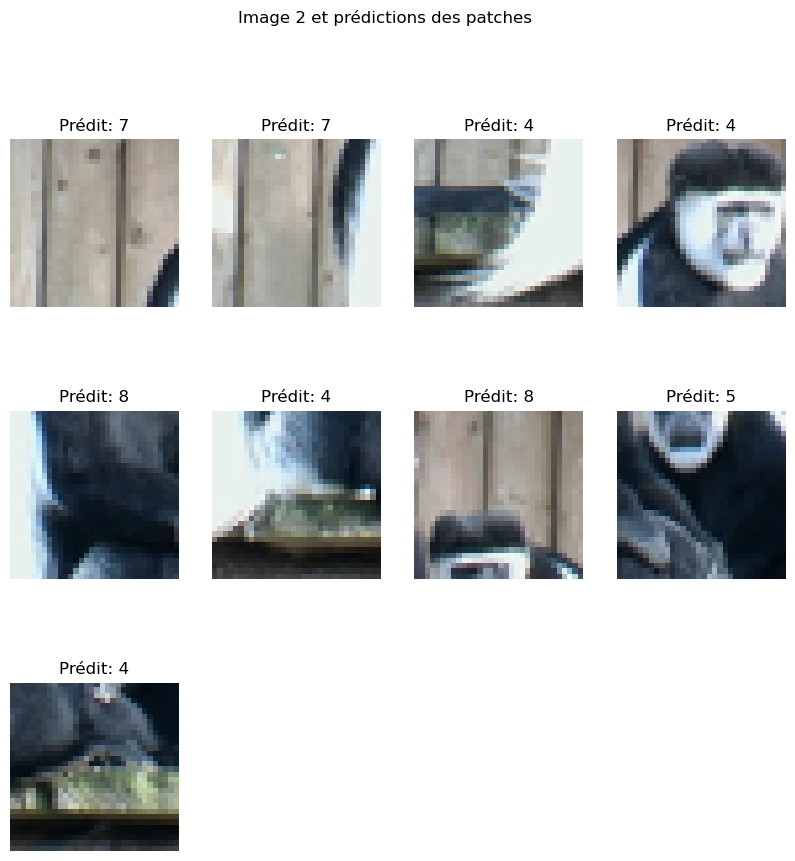

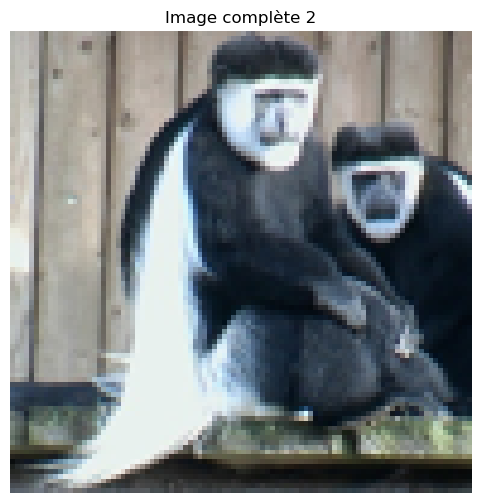

1/1 [==============================] - 0s 16ms/step


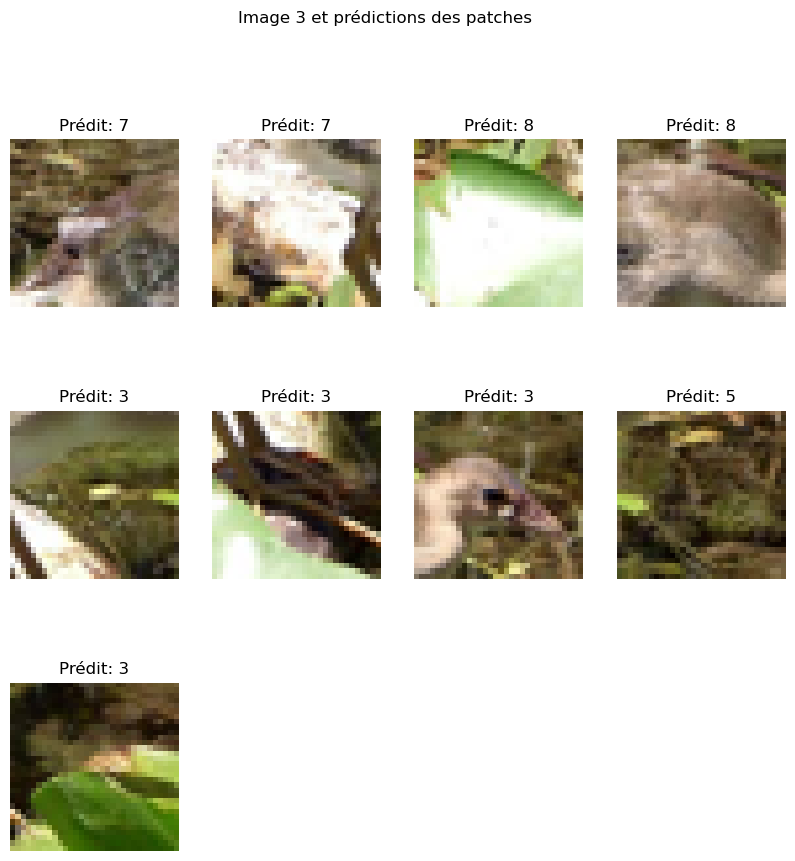

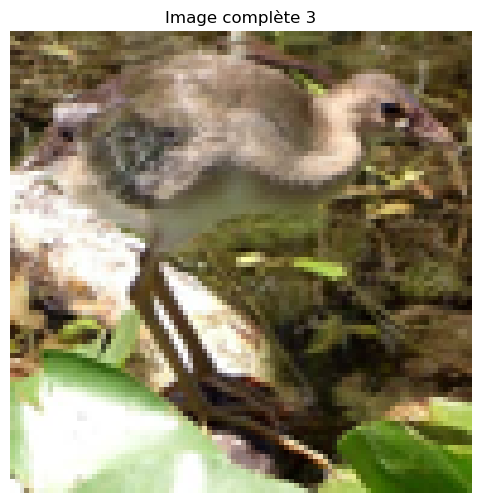

1/1 [==============================] - 0s 16ms/step


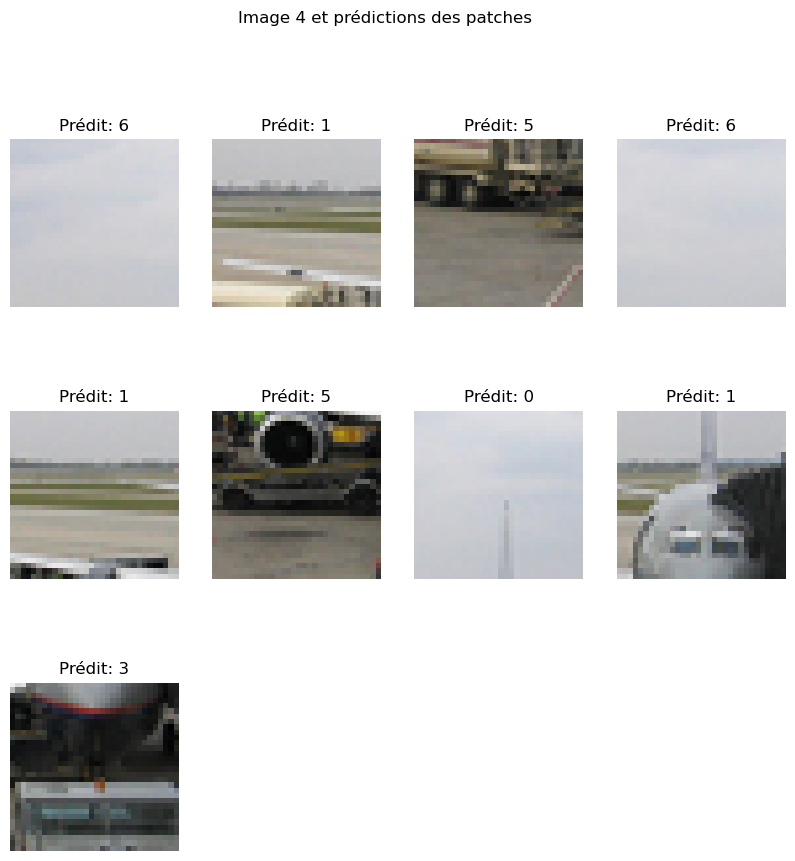

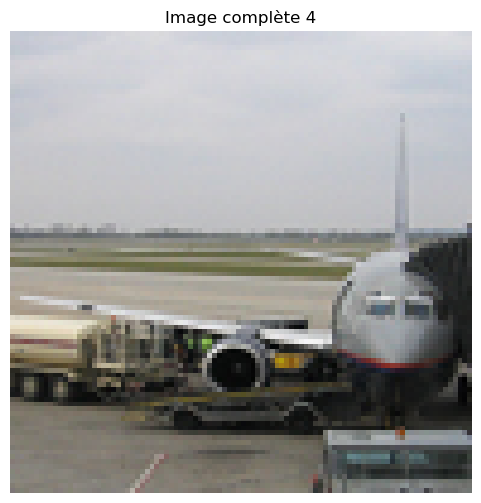

1/1 [==============================] - 0s 15ms/step


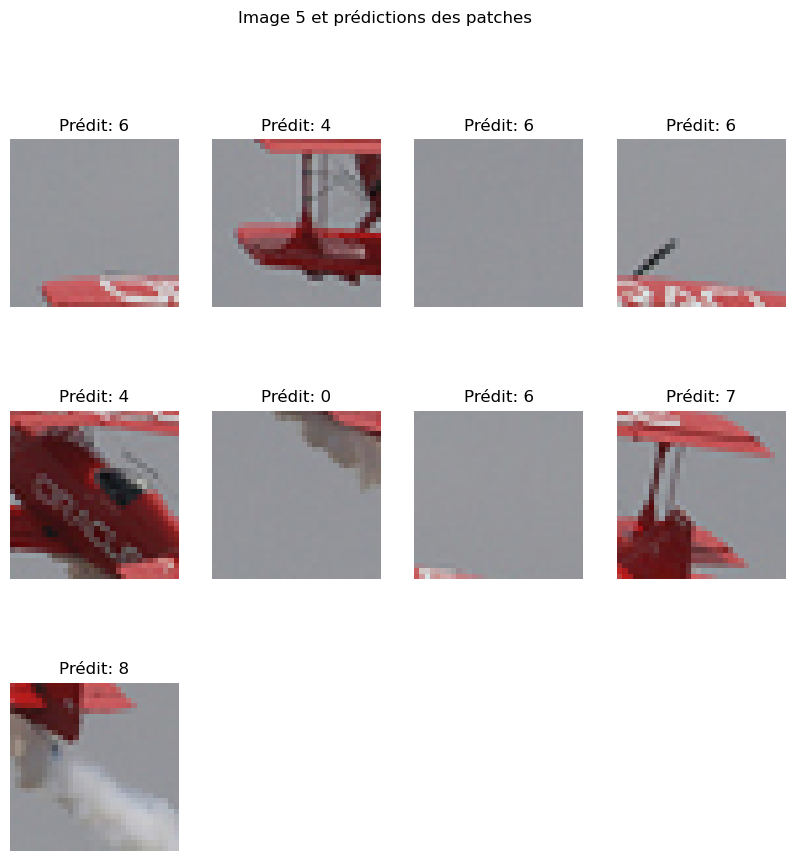

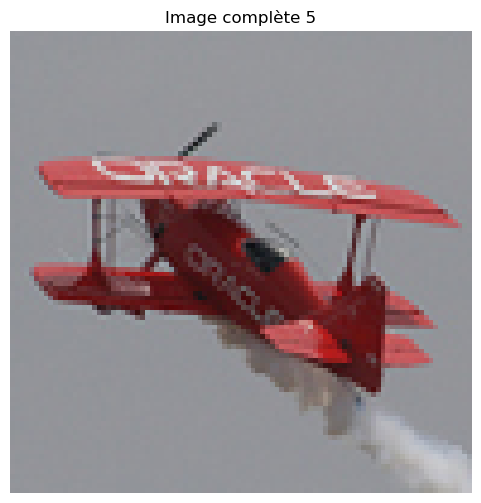

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import cv2

# Fonction pour générer des paires de patchs et des étiquettes de position relative
def generate_patch_pairs(images, n_rows, n_cols):
    patch_list = []
    labels = []
    
    for image in images:
        patches = split_image_to_patches(image, n_rows, n_cols)
        num_patches = len(patches)
        
        for i in range(num_patches):
            patch_list.append(patches[i])
            labels.append(i) 
    
    return np.array(patch_list), np.array(labels)


num_images_to_process = 100  
X, labels = generate_patch_pairs(images[:num_images_to_process], n_rows, n_cols)

# Préparer les données pour l'entraînement
X = np.array([cv2.resize(patch, (32, 32)) for patch in X])  
X = X / 255.0  # Normalisation
y = tf.keras.utils.to_categorical(labels, num_classes=9)


def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (2, 2), activation='relu'),
        layers.Conv2D(512, (2, 2), activation='relu'), 
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),  
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(9, activation='softmax')  
    ])
    return model

input_shape = (32, 32, 3)
model = create_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

# Afficher l'avancement de chaque époque
plt.plot(history.history['accuracy'], label='Précision (entraînement)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Avancement de l'entraînement du modèle")
plt.show()

# Tester le modèle sur de nouvelles images
num_test_images = 5
for idx in range(num_test_images):
    test_image = images[num_images_to_process + idx]
    test_patches = split_image_to_patches(test_image, n_rows, n_cols)
    
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Image {idx + 1} et prédictions des patches")
    
    for i in range(len(test_patches)):
        patch = cv2.resize(test_patches[i], (32, 32)) / 255.0
        prediction = model.predict(np.expand_dims(patch, axis=0))
        predicted_label = np.argmax(prediction)
        
        # Afficher l'image et le patch
        plt.subplot(n_rows, n_cols + 1, i + 1)
        plt.imshow(cv2.cvtColor(test_patches[i], cv2.COLOR_BGR2RGB).transpose(1, 0, 2))
        plt.title(f"Prédit: {predicted_label}")
        plt.axis('off')
    
    plt.show()
    
    # Afficher l'image complète avec les prédictions des patches
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB).transpose(1, 0, 2))
    plt.title(f"Image complète {idx + 1}")
    plt.axis('off')
    plt.show()


CIFAR 10

Epoch 1/30
24/24 [==============================] - 2s 67ms/step - loss: 3.8247 - accuracy: 0.1648 - val_loss: 2.6938 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/30
24/24 [==============================] - 1s 46ms/step - loss: 2.9225 - accuracy: 0.2163 - val_loss: 2.6790 - val_accuracy: 0.1252 - lr: 0.0010
Epoch 3/30
24/24 [==============================] - 1s 45ms/step - loss: 2.6262 - accuracy: 0.2558 - val_loss: 2.6620 - val_accuracy: 0.1277 - lr: 0.0010
Epoch 4/30
24/24 [==============================] - 1s 45ms/step - loss: 2.4755 - accuracy: 0.2833 - val_loss: 2.6474 - val_accuracy: 0.1390 - lr: 0.0010
Epoch 5/30
24/24 [==============================] - 1s 45ms/step - loss: 2.3663 - accuracy: 0.3109 - val_loss: 2.6257 - val_accuracy: 0.1251 - lr: 0.0010
Epoch 6/30
24/24 [==============================] - 1s 45ms/step - loss: 2.2956 - accuracy: 0.3360 - val_loss: 2.6130 - val_accuracy: 0.1419 - lr: 0.0010
Epoch 7/30
24/24 [==============================] - 1s 45ms/step - loss: 2.2

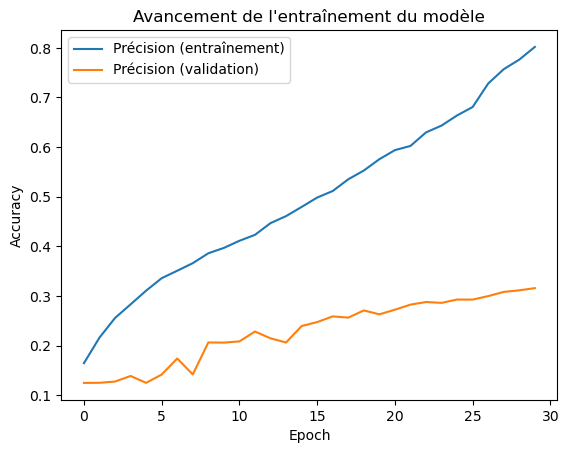

1/1 [==============================] - 0s 18ms/step


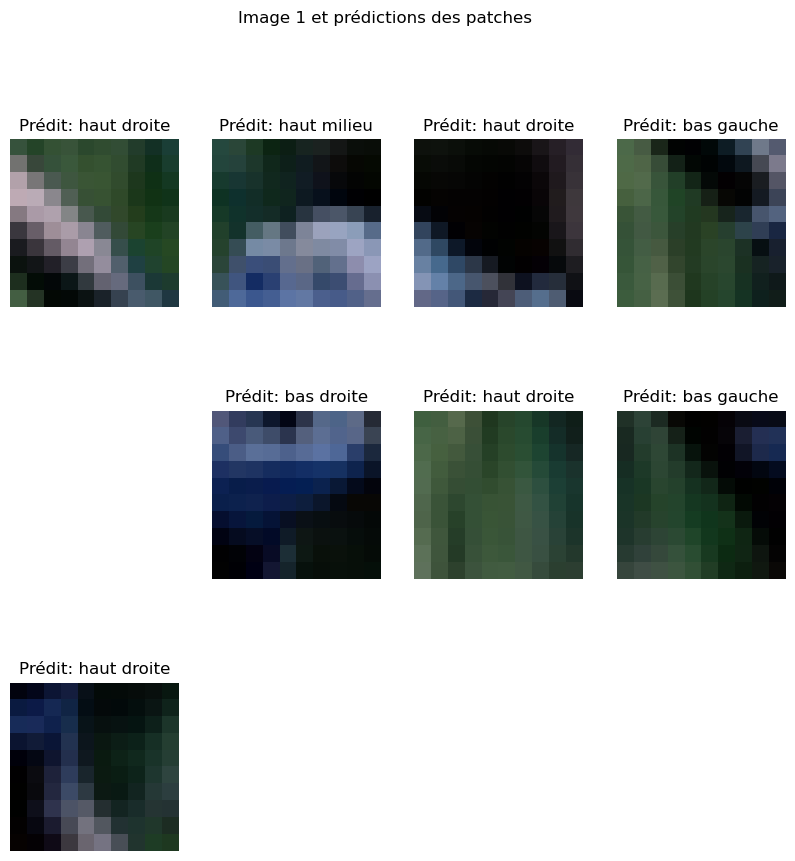

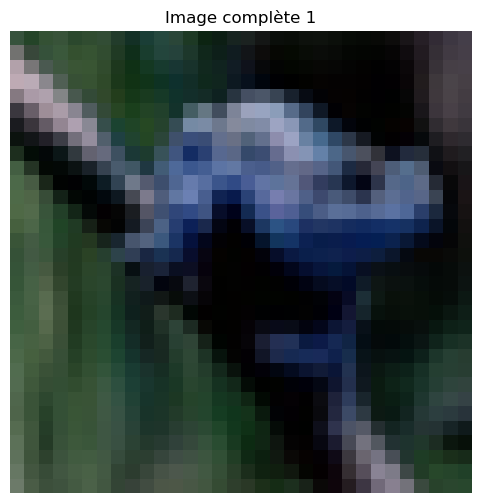

1/1 [==============================] - 0s 16ms/step


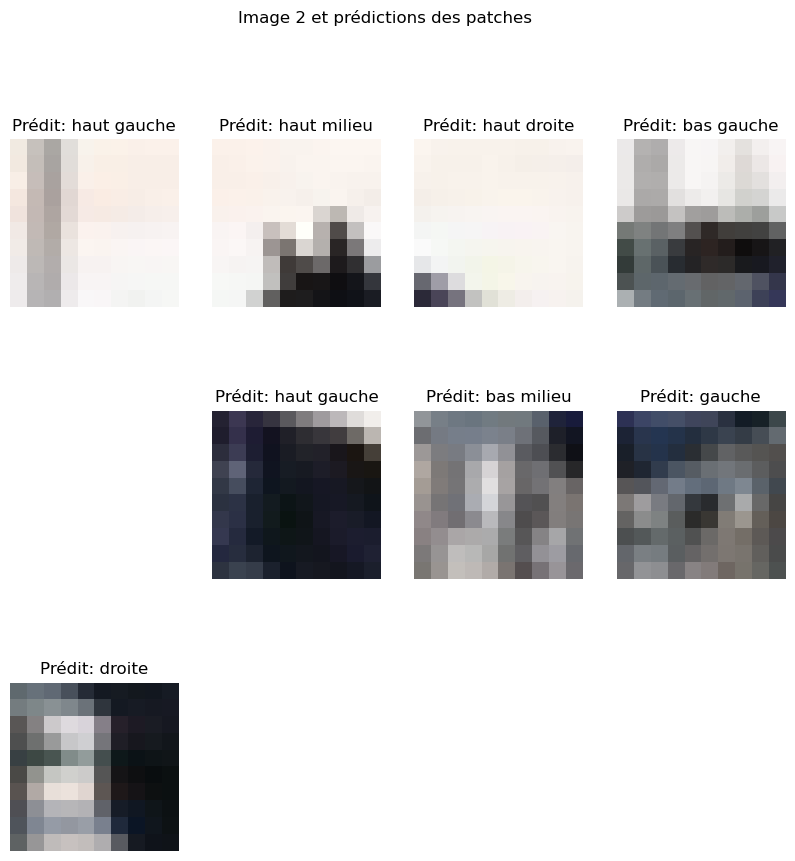

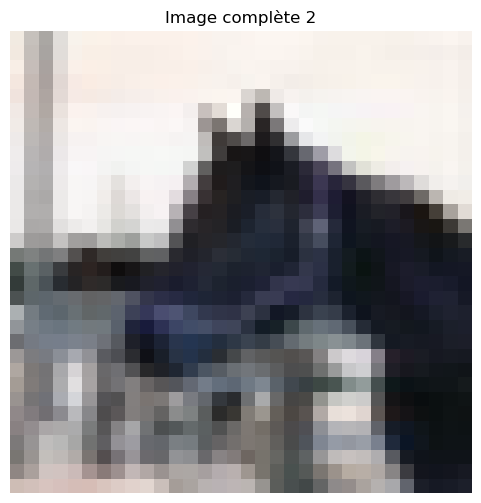

1/1 [==============================] - 0s 17ms/step


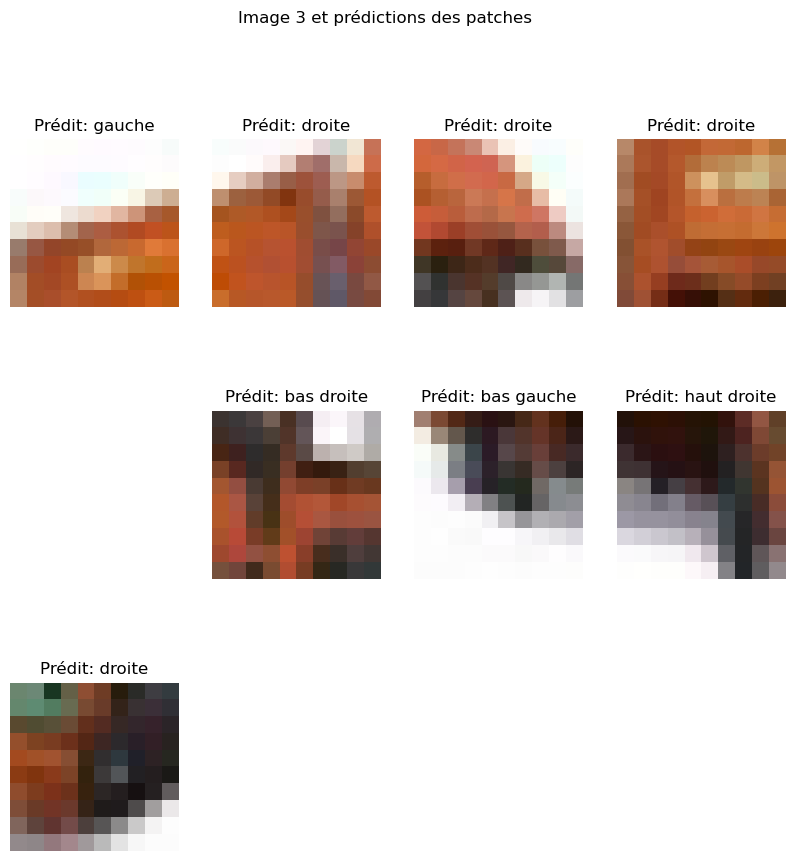

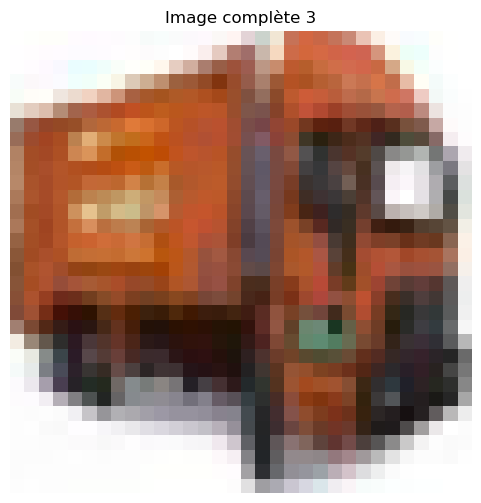

1/1 [==============================] - 0s 16ms/step


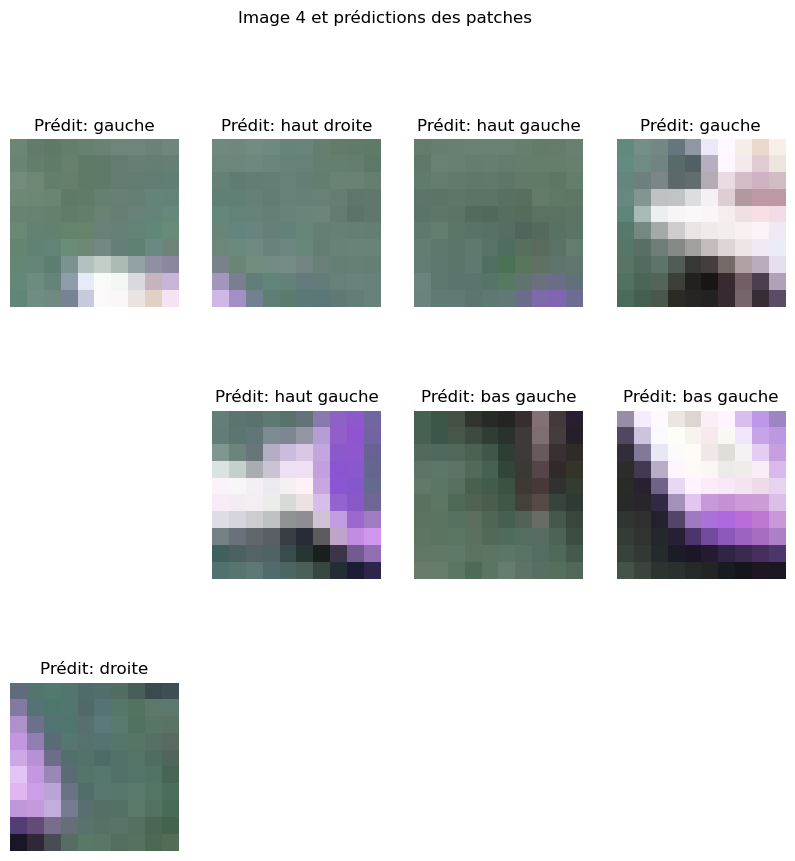

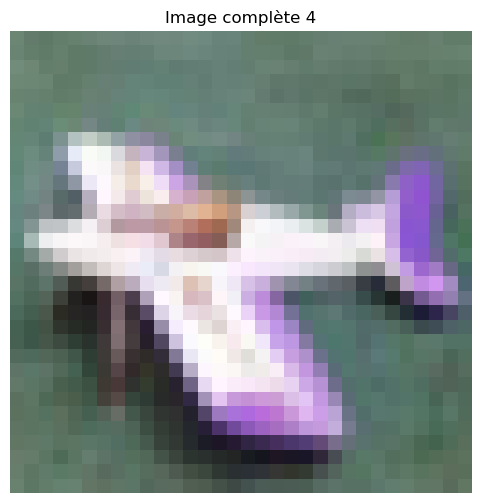

1/1 [==============================] - 0s 17ms/step


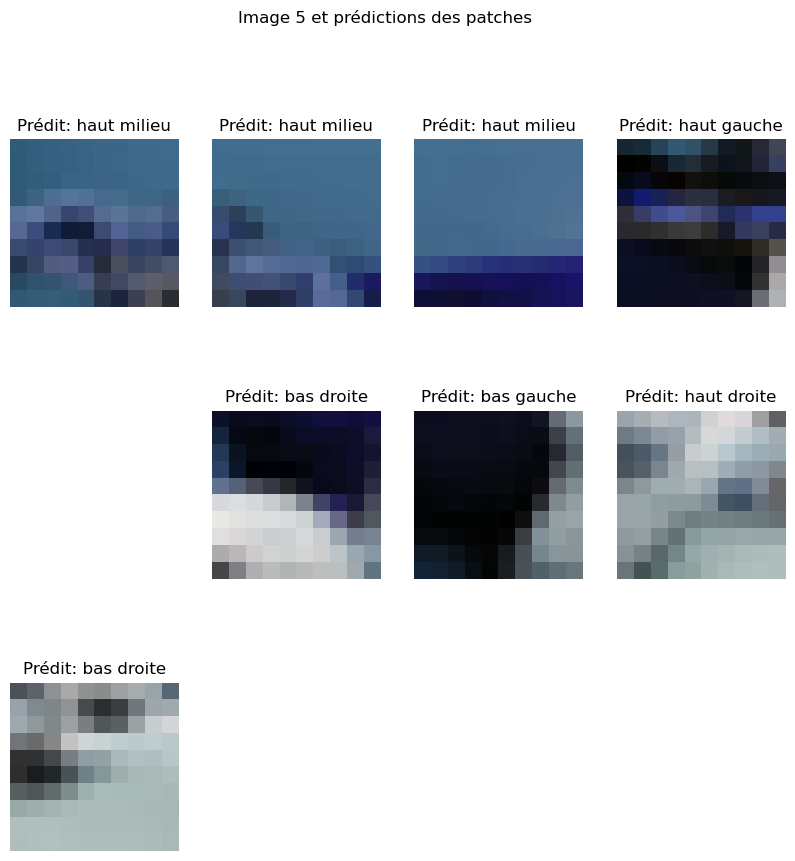

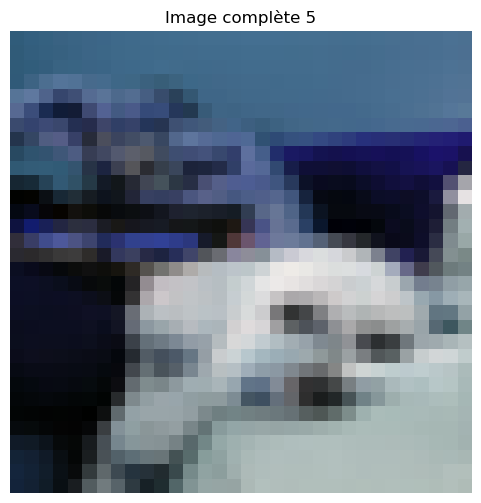

In [92]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Charger le jeu de données CIFAR-10
(train_images, _), (test_images, _) = cifar10.load_data()
images = np.concatenate((train_images, test_images), axis=0)

# Définir le nombre de lignes et colonnes pour diviser les images en patches
n_rows, n_cols = 3, 3

# Fonction pour diviser une image en patches
def split_image_to_patches(image, n_rows, n_cols):
    height, width, _ = image.shape
    patch_height, patch_width = height // n_rows, width // n_cols
    patches = []
    for i in range(n_rows):
        for j in range(n_cols):
            patch = image[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width]
            patches.append(patch)
    return patches

# Fonction pour générer des paires de patchs et des étiquettes de position relative
def generate_patch_pairs(images, n_rows, n_cols):
    patch_list = []
    labels = []
    central_patch_index = (n_rows // 2) * n_cols + (n_cols // 2)
    
    for image in images:
        patches = split_image_to_patches(image, n_rows, n_cols)
        
        for i, patch in enumerate(patches):
            if i == central_patch_index:
                continue  # Ignorer le patch central
            patch_list.append(patch)
            # Calculer la position relative par rapport au patch central
            row_offset = (i // n_cols) - (central_patch_index // n_cols)
            col_offset = (i % n_cols) - (central_patch_index % n_cols)
            labels.append((row_offset, col_offset))
    
    return np.array(patch_list), np.array(labels)

# Générer les paires de patchs et les étiquettes
num_images_to_process = 5000
X, labels = generate_patch_pairs(images[:num_images_to_process], n_rows, n_cols)

# Préparer les données pour l'entraînement
X = np.array([cv2.resize(patch, (32, 32)) for patch in X])  # Redimensionner les patches à 32x32
X = X / 255.0  # Normalisation

# Convertir les étiquettes en un format utilisable par le modèle
def relative_position_to_class(row_offset, col_offset):
    position_map = {
        (-1, -1): 0, (-1, 0): 1, (-1, 1): 2,
        (0, -1): 3, (0, 1): 4,  # Exclure la position (0, 0) qui est le patch central
        (1, -1): 5, (1, 0): 6, (1, 1): 7,
    }
    return position_map[(row_offset, col_offset)]

y = tf.keras.utils.to_categorical([relative_position_to_class(row, col) for row, col in labels], num_classes=8)

# Créer un modèle de réseau de neurones pour prédire la position relative du patch
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (2, 2), activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (2, 2), activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(8, activation='softmax')  # Prédire l'index du patch (0-7)
    ])
    return model

# Créer et compiler le modèle
input_shape = (32, 32, 3)
model = create_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ajouter des callbacks pour améliorer la précision
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Entraîner le modèle
history = model.fit(X, y, epochs=30, batch_size=1024, validation_split=0.4, callbacks=[reduce_lr])

# Afficher l'avancement de chaque époque
plt.plot(history.history['accuracy'], label='Précision (entraînement)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Avancement de l'entraînement du modèle")
plt.show()

# Fonction de mappage des classes à des positions relatives
def class_to_relative_position(class_index):
    position_map = {
        0: "haut gauche", 1: "haut milieu", 2: "haut droite",
        3: "gauche", 4: "droite",
        5: "bas gauche", 6: "bas milieu", 7: "bas droite",
    }
    return position_map[class_index]

# Tester le modèle sur de nouvelles images
central_patch_index = (n_rows // 2) * n_cols + (n_cols // 2)

num_test_images = 5
for idx in range(num_test_images):
    test_image = images[num_images_to_process + idx]
    test_patches = split_image_to_patches(test_image, n_rows, n_cols)
    
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Image {idx + 1} et prédictions des patches")
    
    for i in range(len(test_patches)):
        if i == central_patch_index:
            continue  # Ignorer le patch central
        patch = cv2.resize(test_patches[i], (32, 32)) / 255.0
        prediction = model.predict(np.expand_dims(patch, axis=0))
        predicted_label = np.argmax(prediction)
        predicted_position = class_to_relative_position(predicted_label)
        
        # Afficher l'image et le patch
        plt.subplot(n_rows, n_cols + 1, i + 1)
        plt.imshow(cv2.cvtColor(test_patches[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Prédit: {predicted_position}")
        plt.axis('off')
    
    plt.show()
    
    # Afficher l'image complète avec les prédictions des patches
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image complète {idx + 1}")
    plt.axis('off')
    plt.show()
